In [1]:
from trainModel import *
from torchData import duneADCdata
from torch.utils.data import random_split
import matplotlib.pyplot as plt
# from SparseCNN import SparseNet
from torchvision import datasets, transforms
from torchDataSparse import duneADCdata, ToTensor
# import sparseconvnet as scn
from scipy.sparse import coo_matrix
# torch.manual_seed(1516989)

In [2]:
import torch
import torch.nn as nn
import sparseconvnet as scn
import torch.nn.functional as F

# from data import get_iterators

# two-dimensional SparseConvNet
class SparseNet(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.sparseModel = scn.Sequential(
            scn.SubmanifoldConvolution(2, 600, 32, 3, False),
            scn.MaxPooling(2, 3, 2),
#             scn.SparseResNet(2, 8, [
#                         ['b', 8, 2, 1],
#                         ['b', 16, 2, 2],
#                         ['b', 24, 2, 2]]),#,
# #                         ['b', 32, 2, 2]]),
#             scn.Dropout(0.1),
#             scn.Convolution(2, 24, 32, 3, 1, False),
#             scn.MaxPooling(2, 3, 2),
#             scn.Convolution(2, 32, 64, 3, 1, False),
#             scn.BatchNormReLU(24),
#             scn.MaxPooling(2, 3, 2),

            scn.SparseToDense(2, 32))
        self.spatial_size= self.sparseModel.input_spatial_size(torch.LongTensor([1, 1]))
            
#         print(self.spatial_size)
#         self.spatial_size=1500#torch.IntTensor(1500)
#         print(self.spatial_size)
        self.inputLayer = scn.InputLayer(dimension = 2,spatial_size = self.spatial_size)
#         self.linear = nn.Linear(16, 8)

        self.linear = nn.Linear(32, 2)

    def forward(self, x):
#         print(x)
        x = self.inputLayer(x)
#         print(x.size())
        x = self.sparseModel(x)
#         print(x.size())

        x = x.view(-1, 32)
        x = F.softmax(self.linear(x))

        print(x)
        return x


In [3]:
net = SparseNet()
# batch_size=32

In [4]:
# transform = transforms.Compose([ToTensor()])
# batch_size = 4#broken, use 1
# data = duneADCdata("seconddata.csv", "./",batch_size=batch_size)#, transform=transform)
# # data = duneADCdata("babydata.csv", "./",batch_size=batch_size)#, transform=transform)

In [5]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
from skimage import io
import numpy as np
from scipy.sparse import coo_matrix
import torch.nn.functional as F
import sys


class toyData(Dataset):
    def __init__(self, batch_size=1,N = 1000):
        self.maxSize = 600
        self.coords = []
        self.features = []
        self.targets = []
        self.N = N
        self.batch_size = batch_size
        self.size = 200
        
        n = int(np.ceil(self.N/self.batch_size))
        for batchIdx in range(self.batch_size):
            for i in range(n):
                s = np.random.uniform()
                img = np.zeros((self.size,self.size))
                if s > 0.5:
                    self.targets.append(1)
#                     for i in range(np.random.randint(1,5)):
                    img[np.random.randint(0,self.size),int(self.size/1.2):-int(self.size/1.2)] = 1

                else:
                    img = np.random.uniform(size=(self.size,self.size))
                    img = img>0.999
                    img = img.astype(int)
                    if np.sum(img==1) == 0:
                        img[np.random.randint(0,self.size),np.random.randint(0,self.size)] = 1
                    self.targets.append(0)

                r = np.random.uniform()
                if r > 0.5:
                    img = img.T
                    
#                 if batchIdx < 10:
#                     print(i)
#                     plt.imshow(img)
#                     plt.show()
                img = coo_matrix(img)
                features = torch.FloatTensor(img.data)
                coordsx = img.row
                coordsy = img.col
                coords = np.dstack((coordsx,coordsy,np.ones(features.size(0))*batchIdx))#batch_size))
                coords = torch.FloatTensor(coords)

                pad1 = (0,self.maxSize-features.size(0))
                pad2 = (0,0,0,self.maxSize-features.size(0))

                coords = F.pad(coords,pad2,'constant',0)
    #             coords[0,:,2] = batch_size

                features = F.pad(features,pad1,'constant',0)
                self.coords.append(coords)
                self.features.append(features)


            
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = {"input": (self.coords[idx],self.features[idx]), "target": self.targets[idx]}
      
        return sample
    

In [21]:
batch_size_ = 1
data = toyData(N=5000)

In [7]:
print(data[0])

{'input': (tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [22]:
# for i in range(10):
#     coords = data[i]['input'][0].numpy().astype(int).reshape(3,-1)[0:2,:]
#     data = data[i]['input'][1].numpy().astype(int)
#     print(type(coords[0]))
#     sparse = coo_matrix(data,coords)
#     dense = sparse.toarray()
#     plt.imshow(dense)
#     plt.show()

In [23]:
# batch_size = 31#broken, use 1
n_epochs=10
# batch_size = 4
classes = ["radio","SNB"]
lengths = [int(len(data)*0.8),int(len(data))-int(len(data)*0.8)]
trainData, testData= random_split(data,lengths)

trainLoader = DataLoader(trainData, batch_size=batch_size_, shuffle=True)
testLoader = DataLoader(testData, batch_size=batch_size_, shuffle=True)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0,weight_decay=0.00001)



In [24]:
net,losses = train(net, trainLoader,optimizer,n_epochs=n_epochs,batch_size=batch_size_,learning_rate=0.001)

Epoch 1/10:
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.4931, 0.5069]], grad_fn=<SoftmaxBackward>)
tensor([[0.4919, 0.5081]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.4859, 0.5141]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], g

tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], g

tensor([[0.5138, 0.4862]], grad_fn=<SoftmaxBackward>)
tensor([[0.5125, 0.4875]], grad_fn=<SoftmaxBackward>)
tensor([[0.5113, 0.4887]], grad_fn=<SoftmaxBackward>)
tensor([[0.5125, 0.4875]], grad_fn=<SoftmaxBackward>)
tensor([[0.5112, 0.4888]], grad_fn=<SoftmaxBackward>)
tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward>)
tensor([[0.5112, 0.4888]], grad_fn=<SoftmaxBackward>)
tensor([[0.5125, 0.4875]], grad_fn=<SoftmaxBackward>)
tensor([[0.5137, 0.4863]], grad_fn=<SoftmaxBackward>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[0.5161, 0.4839]], grad_fn=<SoftmaxBackward>)
tensor([[0.5174, 0.4826]], grad_fn=<SoftmaxBackward>)
tensor([[0.5186, 0.4814]], grad_fn=<SoftmaxBackward>)
tensor([[0.5173, 0.4827]], grad_fn=<SoftmaxBackward>)
tensor([[0.5161, 0.4839]], grad_fn=<SoftmaxBackward>)
tensor([[0.5173, 0.4827]], grad_fn=<SoftmaxBackward>)
tensor([[0.5185, 0.4815]], grad_fn=<SoftmaxBackward>)
tensor([[0.5197, 0.4803]], grad_fn=<SoftmaxBackward>)
tensor([[0.5210, 0.4790]], g

tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], g

tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4706, 0.5294]], grad_fn=<SoftmaxBackward>)
tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4662, 0.5338]], grad_fn=<SoftmaxBackward>)
tensor([[0.4650, 0.5350]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], g

tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], g

tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.5773, 0.4227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], g

tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], g

tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[0.4727, 0.5273]], grad_fn=<SoftmaxBackward>)
tensor([[0.4739, 0.5261]], grad_fn=<SoftmaxBackward>)
tensor([[0.4752, 0.5248]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], g

tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], g

tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5023, 0.4977]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5023, 0.4977]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.4998, 0.5002]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4998, 0.5002]], grad_fn=<SoftmaxBackward>)
tensor([[0.6150, 0.3850]], g

tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], g

tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], grad_fn=<SoftmaxBackward>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.4751, 0.5249]], grad_fn=<SoftmaxBackward>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.6094, 0.3906]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], g

tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], g

tensor([[0.4691, 0.5309]], grad_fn=<SoftmaxBackward>)
tensor([[0.4703, 0.5297]], grad_fn=<SoftmaxBackward>)
tensor([[0.4716, 0.5284]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.4717, 0.5283]], grad_fn=<SoftmaxBackward>)
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
tensor([[0.4717, 0.5283]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], g

tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4637, 0.5363]], grad_fn=<SoftmaxBackward>)
tensor([[0.4649, 0.5351]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], g

tensor([[0.4628, 0.5372]], grad_fn=<SoftmaxBackward>)
tensor([[0.4616, 0.5384]], grad_fn=<SoftmaxBackward>)
tensor([[0.4629, 0.5371]], grad_fn=<SoftmaxBackward>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], g

tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], g

tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4751, 0.5249]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], grad_fn=<SoftmaxBackward>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4690, 0.5310]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4631, 0.5369]], g

tensor([[0.4695, 0.5305]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], g

tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4943, 0.5057]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4943, 0.5057]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4943, 0.5057]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], g

tensor([[0.4987, 0.5013]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4987, 0.5013]], grad_fn=<SoftmaxBackward>)
tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward>)
tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward>)
tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward>)
tensor([[0.4987, 0.5013]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
tensor([[0.4950, 0.5050]], grad_fn=<SoftmaxBackward>)
tensor([[0.4938, 0.5062]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], g

tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], g

tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], g

tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.6923, 0.3077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], g

tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5061, 0.4939]], grad_fn=<SoftmaxBackward>)
tensor([[0.5073, 0.4927]], grad_fn=<SoftmaxBackward>)
tensor([[0.5061, 0.4939]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5023, 0.4977]], g

tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], g

tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], g

tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], g

tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], g

tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], g

tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4649, 0.5351]], grad_fn=<SoftmaxBackward>)
tensor([[0.4637, 0.5363]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.4651, 0.5349]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], grad_fn=<SoftmaxBackward>)
tensor([[0.4592, 0.5408]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4618, 0.5382]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], g

tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.7047, 0.2953]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4628, 0.5372]], grad_fn=<SoftmaxBackward>)
tensor([[0.4616, 0.5384]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], grad_fn=<SoftmaxBackward>)
tensor([[0.4617, 0.5383]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4618, 0.5382]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4646, 0.5354]], g

tensor([[0.4538, 0.5462]], grad_fn=<SoftmaxBackward>)
tensor([[0.4527, 0.5473]], grad_fn=<SoftmaxBackward>)
tensor([[0.4515, 0.5485]], grad_fn=<SoftmaxBackward>)
tensor([[0.4528, 0.5472]], grad_fn=<SoftmaxBackward>)
tensor([[0.4541, 0.5459]], grad_fn=<SoftmaxBackward>)
tensor([[0.4554, 0.5446]], grad_fn=<SoftmaxBackward>)
tensor([[0.7261, 0.2739]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4552, 0.5448]], grad_fn=<SoftmaxBackward>)
tensor([[0.4540, 0.5460]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], grad_fn=<SoftmaxBackward>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4578, 0.5422]], grad_fn=<SoftmaxBackward>)
tensor([[0.4591, 0.5409]], grad_fn=<SoftmaxBackward>)
tensor([[0.4579, 0.5421]], grad_fn=<SoftmaxBackward>)
tensor([[0.4592, 0.5408]], g

tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
tensor([[0.4544, 0.5456]], grad_fn=<SoftmaxBackward>)
tensor([[0.4557, 0.5443]], grad_fn=<SoftmaxBackward>)
tensor([[0.4545, 0.5455]], grad_fn=<SoftmaxBackward>)
tensor([[0.4558, 0.5442]], grad_fn=<SoftmaxBackward>)
tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[0.4572, 0.5428]], grad_fn=<SoftmaxBackward>)
tensor([[0.4560, 0.5440]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4561, 0.5439]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4562, 0.5438]], grad_fn=<SoftmaxBackward>)
tensor([[0.4550, 0.5450]], grad_fn=<SoftmaxBackward>)
tensor([[0.4539, 0.5461]], grad_fn=<SoftmaxBackward>)
tensor([[0.4551, 0.5449]], grad_fn=<SoftmaxBackward>)
tensor([[0.4540, 0.5460]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], g

tensor([[0.4390, 0.5610]], grad_fn=<SoftmaxBackward>)
tensor([[0.4403, 0.5597]], grad_fn=<SoftmaxBackward>)
tensor([[0.4392, 0.5608]], grad_fn=<SoftmaxBackward>)
tensor([[0.4404, 0.5596]], grad_fn=<SoftmaxBackward>)
tensor([[0.4417, 0.5583]], grad_fn=<SoftmaxBackward>)
tensor([[0.4430, 0.5570]], grad_fn=<SoftmaxBackward>)
tensor([[0.4443, 0.5557]], grad_fn=<SoftmaxBackward>)
tensor([[0.4432, 0.5568]], grad_fn=<SoftmaxBackward>)
tensor([[0.4420, 0.5580]], grad_fn=<SoftmaxBackward>)
tensor([[0.4433, 0.5567]], grad_fn=<SoftmaxBackward>)
tensor([[0.4421, 0.5579]], grad_fn=<SoftmaxBackward>)
tensor([[0.4434, 0.5566]], grad_fn=<SoftmaxBackward>)
tensor([[0.4423, 0.5577]], grad_fn=<SoftmaxBackward>)
tensor([[0.4436, 0.5564]], grad_fn=<SoftmaxBackward>)
tensor([[0.4424, 0.5576]], grad_fn=<SoftmaxBackward>)
tensor([[0.4437, 0.5563]], grad_fn=<SoftmaxBackward>)
tensor([[0.4426, 0.5574]], grad_fn=<SoftmaxBackward>)
tensor([[0.4414, 0.5586]], grad_fn=<SoftmaxBackward>)
tensor([[0.4403, 0.5597]], g

tensor([[0.4532, 0.5468]], grad_fn=<SoftmaxBackward>)
tensor([[0.4521, 0.5479]], grad_fn=<SoftmaxBackward>)
tensor([[0.4534, 0.5466]], grad_fn=<SoftmaxBackward>)
tensor([[0.4547, 0.5453]], grad_fn=<SoftmaxBackward>)
tensor([[0.4535, 0.5465]], grad_fn=<SoftmaxBackward>)
tensor([[0.4523, 0.5477]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[0.4513, 0.5487]], grad_fn=<SoftmaxBackward>)
tensor([[0.4525, 0.5475]], grad_fn=<SoftmaxBackward>)
tensor([[0.4514, 0.5486]], grad_fn=<SoftmaxBackward>)
tensor([[0.4502, 0.5498]], grad_fn=<SoftmaxBackward>)
tensor([[0.4490, 0.5510]], grad_fn=<SoftmaxBackward>)
tensor([[0.4479, 0.5521]], grad_fn=<SoftmaxBackward>)
tensor([[0.4492, 0.5508]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4506, 0.5494]], grad_fn=<SoftmaxBackward>)
tensor([[0.4519, 0.5481]], g

tensor([[0.4359, 0.5641]], grad_fn=<SoftmaxBackward>)
tensor([[0.4371, 0.5629]], grad_fn=<SoftmaxBackward>)
tensor([[0.4360, 0.5640]], grad_fn=<SoftmaxBackward>)
tensor([[0.4349, 0.5651]], grad_fn=<SoftmaxBackward>)
tensor([[0.4337, 0.5663]], grad_fn=<SoftmaxBackward>)
tensor([[0.4350, 0.5650]], grad_fn=<SoftmaxBackward>)
tensor([[0.4363, 0.5637]], grad_fn=<SoftmaxBackward>)
tensor([[0.4352, 0.5648]], grad_fn=<SoftmaxBackward>)
tensor([[0.4365, 0.5635]], grad_fn=<SoftmaxBackward>)
tensor([[0.4378, 0.5622]], grad_fn=<SoftmaxBackward>)
tensor([[0.4390, 0.5610]], grad_fn=<SoftmaxBackward>)
tensor([[0.4379, 0.5621]], grad_fn=<SoftmaxBackward>)
tensor([[0.4368, 0.5632]], grad_fn=<SoftmaxBackward>)
tensor([[0.4356, 0.5644]], grad_fn=<SoftmaxBackward>)
tensor([[0.4345, 0.5655]], grad_fn=<SoftmaxBackward>)
tensor([[0.4334, 0.5666]], grad_fn=<SoftmaxBackward>)
tensor([[0.4347, 0.5653]], grad_fn=<SoftmaxBackward>)
tensor([[0.4360, 0.5640]], grad_fn=<SoftmaxBackward>)
tensor([[0.4348, 0.5652]], g

tensor([[0.4322, 0.5678]], grad_fn=<SoftmaxBackward>)
tensor([[0.4335, 0.5665]], grad_fn=<SoftmaxBackward>)
tensor([[0.4324, 0.5676]], grad_fn=<SoftmaxBackward>)
tensor([[0.4312, 0.5688]], grad_fn=<SoftmaxBackward>)
tensor([[0.4301, 0.5699]], grad_fn=<SoftmaxBackward>)
tensor([[0.4314, 0.5686]], grad_fn=<SoftmaxBackward>)
tensor([[0.4303, 0.5697]], grad_fn=<SoftmaxBackward>)
tensor([[0.4292, 0.5708]], grad_fn=<SoftmaxBackward>)
tensor([[0.4281, 0.5719]], grad_fn=<SoftmaxBackward>)
tensor([[0.4293, 0.5707]], grad_fn=<SoftmaxBackward>)
tensor([[0.4282, 0.5718]], grad_fn=<SoftmaxBackward>)
tensor([[0.4271, 0.5729]], grad_fn=<SoftmaxBackward>)
tensor([[0.4284, 0.5716]], grad_fn=<SoftmaxBackward>)
tensor([[0.4273, 0.5727]], grad_fn=<SoftmaxBackward>)
tensor([[0.4286, 0.5714]], grad_fn=<SoftmaxBackward>)
tensor([[0.4275, 0.5725]], grad_fn=<SoftmaxBackward>)
tensor([[0.4287, 0.5713]], grad_fn=<SoftmaxBackward>)
tensor([[0.4300, 0.5700]], grad_fn=<SoftmaxBackward>)
tensor([[0.4313, 0.5687]], g

tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4602, 0.5398]], grad_fn=<SoftmaxBackward>)
tensor([[0.4590, 0.5410]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], grad_fn=<SoftmaxBackward>)
tensor([[0.4616, 0.5384]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], grad_fn=<SoftmaxBackward>)
tensor([[0.4617, 0.5383]], grad_fn=<SoftmaxBackward>)
tensor([[0.4630, 0.5370]], grad_fn=<SoftmaxBackward>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4631, 0.5369]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], g

tensor([[0.4715, 0.5285]], grad_fn=<SoftmaxBackward>)
tensor([[0.4703, 0.5297]], grad_fn=<SoftmaxBackward>)
tensor([[0.4716, 0.5284]], grad_fn=<SoftmaxBackward>)
tensor([[0.4728, 0.5272]], grad_fn=<SoftmaxBackward>)
tensor([[0.4716, 0.5284]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.7539, 0.2461]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[0.4727, 0.5273]], grad_fn=<SoftmaxBackward>)
tensor([[0.4715, 0.5285]], grad_fn=<SoftmaxBackward>)
tensor([[0.4727, 0.5273]], grad_fn=<SoftmaxBackward>)
tensor([[0.4740, 0.5260]], g

tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.4650, 0.5350]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.7621, 0.2379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4646, 0.5354]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], g

tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5055, 0.4945]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5030, 0.4970]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[0.5116, 0.4884]], g

tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4941, 0.5059]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], g

tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], g

tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], g

tensor([[0.5157, 0.4843]], grad_fn=<SoftmaxBackward>)
tensor([[0.5169, 0.4831]], grad_fn=<SoftmaxBackward>)
tensor([[0.5181, 0.4819]], grad_fn=<SoftmaxBackward>)
tensor([[0.5169, 0.4831]], grad_fn=<SoftmaxBackward>)
tensor([[0.5181, 0.4819]], grad_fn=<SoftmaxBackward>)
tensor([[0.5193, 0.4807]], grad_fn=<SoftmaxBackward>)
tensor([[0.5180, 0.4820]], grad_fn=<SoftmaxBackward>)
tensor([[0.5168, 0.4832]], grad_fn=<SoftmaxBackward>)
tensor([[0.5155, 0.4845]], grad_fn=<SoftmaxBackward>)
tensor([[0.5167, 0.4833]], grad_fn=<SoftmaxBackward>)
tensor([[0.5155, 0.4845]], grad_fn=<SoftmaxBackward>)
tensor([[0.5167, 0.4833]], grad_fn=<SoftmaxBackward>)
tensor([[0.5179, 0.4821]], grad_fn=<SoftmaxBackward>)
tensor([[0.5191, 0.4809]], grad_fn=<SoftmaxBackward>)
tensor([[0.5204, 0.4796]], grad_fn=<SoftmaxBackward>)
tensor([[0.5191, 0.4809]], grad_fn=<SoftmaxBackward>)
tensor([[0.5203, 0.4797]], grad_fn=<SoftmaxBackward>)
tensor([[0.5215, 0.4785]], grad_fn=<SoftmaxBackward>)
tensor([[0.5203, 0.4797]], g

tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.5017, 0.4983]], grad_fn=<SoftmaxBackward>)
tensor([[0.5030, 0.4970]], grad_fn=<SoftmaxBackward>)
tensor([[0.5017, 0.4983]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.5017, 0.4983]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], g

tensor([[0.4984, 0.5016]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4984, 0.5016]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.4984, 0.5016]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.5009, 0.4991]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5009, 0.4991]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.5009, 0.4991]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5034, 0.4966]], grad_fn=<SoftmaxBackward>)
tensor([[0.5046, 0.4954]], grad_fn=<SoftmaxBackward>)
tensor([[0.5034, 0.4966]], grad_fn=<SoftmaxBackward>)
tensor([[0.5046, 0.4954]], grad_fn=<SoftmaxBackward>)
tensor([[0.5058, 0.4942]], grad_fn=<SoftmaxBackward>)
tensor([[0.5071, 0.4929]], grad_fn=<SoftmaxBackward>)
tensor([[0.5058, 0.4942]], g

tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], g

tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4985, 0.5015]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], g

tensor([[0.4985, 0.5015]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], g

tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4935, 0.5065]], grad_fn=<SoftmaxBackward>)
tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.5019, 0.4981]], grad_fn=<SoftmaxBackward>)
tensor([[0.5032, 0.4968]], grad_fn=<SoftmaxBackward>)
tensor([[0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)
tensor([[0.5032, 0.4968]], grad_fn=<SoftmaxBackward>)
tensor([[0.5019, 0.4981]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.5019, 0.4981]], g

tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5056, 0.4944]], grad_fn=<SoftmaxBackward>)
tensor([[0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)
tensor([[0.5056, 0.4944]], grad_fn=<SoftmaxBackward>)
tensor([[0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)
tensor([[0.5056, 0.4944]], grad_fn=<SoftmaxBackward>)
tensor([[0.5043, 0.4957]], grad_fn=<SoftmaxBackward>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[0.5043, 0.4957]], grad_fn=<SoftmaxBackward>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward>)
tensor([[0.5006, 0.4994]], g

tensor([[0.5111, 0.4889]], grad_fn=<SoftmaxBackward>)
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
tensor([[0.5111, 0.4889]], grad_fn=<SoftmaxBackward>)
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
tensor([[0.5136, 0.4864]], grad_fn=<SoftmaxBackward>)
tensor([[0.5123, 0.4877]], grad_fn=<SoftmaxBackward>)
tensor([[0.5111, 0.4889]], grad_fn=<SoftmaxBackward>)
tensor([[0.5123, 0.4877]], grad_fn=<SoftmaxBackward>)
tensor([[0.5110, 0.4890]], grad_fn=<SoftmaxBackward>)
tensor([[0.5123, 0.4877]], grad_fn=<SoftmaxBackward>)
tensor([[0.5110, 0.4890]], grad_fn=<SoftmaxBackward>)
tensor([[0.5122, 0.4878]], grad_fn=<SoftmaxBackward>)
tensor([[0.5135, 0.4865]], grad_fn=<SoftmaxBackward>)
tensor([[0.5147, 0.4853]], grad_fn=<SoftmaxBackward>)
tensor([[0.5159, 0.4841]], grad_fn=<SoftmaxBackward>)
tensor([[0.5172, 0.4828]], grad_fn=<SoftmaxBackward>)
tensor([[0.5184, 0.4816]], grad_fn=<SoftmaxBackward>)
tensor([[0.5171, 0.4829]], grad_fn=<SoftmaxBackward>)
tensor([[0.5158, 0.4842]], g

tensor([[0.5135, 0.4865]], grad_fn=<SoftmaxBackward>)
tensor([[0.5148, 0.4852]], grad_fn=<SoftmaxBackward>)
tensor([[0.5135, 0.4865]], grad_fn=<SoftmaxBackward>)
tensor([[0.5147, 0.4853]], grad_fn=<SoftmaxBackward>)
tensor([[0.5135, 0.4865]], grad_fn=<SoftmaxBackward>)
tensor([[0.5147, 0.4853]], grad_fn=<SoftmaxBackward>)
tensor([[0.5134, 0.4866]], grad_fn=<SoftmaxBackward>)
tensor([[0.5147, 0.4853]], grad_fn=<SoftmaxBackward>)
tensor([[0.5134, 0.4866]], grad_fn=<SoftmaxBackward>)
tensor([[0.5146, 0.4854]], grad_fn=<SoftmaxBackward>)
tensor([[0.5134, 0.4866]], grad_fn=<SoftmaxBackward>)
tensor([[0.5121, 0.4879]], grad_fn=<SoftmaxBackward>)
tensor([[0.5133, 0.4867]], grad_fn=<SoftmaxBackward>)
tensor([[0.5146, 0.4854]], grad_fn=<SoftmaxBackward>)
tensor([[0.5158, 0.4842]], grad_fn=<SoftmaxBackward>)
tensor([[0.5170, 0.4830]], grad_fn=<SoftmaxBackward>)
tensor([[0.5183, 0.4817]], grad_fn=<SoftmaxBackward>)
tensor([[0.5170, 0.4830]], grad_fn=<SoftmaxBackward>)
tensor([[0.5157, 0.4843]], g

tensor([[0.5037, 0.4963]], grad_fn=<SoftmaxBackward>)
tensor([[0.5050, 0.4950]], grad_fn=<SoftmaxBackward>)
tensor([[0.5062, 0.4938]], grad_fn=<SoftmaxBackward>)
tensor([[0.5050, 0.4950]], grad_fn=<SoftmaxBackward>)
tensor([[0.5037, 0.4963]], grad_fn=<SoftmaxBackward>)
tensor([[0.5025, 0.4975]], grad_fn=<SoftmaxBackward>)
tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5037, 0.4963]], grad_fn=<SoftmaxBackward>)
tensor([[0.5049, 0.4951]], grad_fn=<SoftmaxBackward>)
tensor([[0.5062, 0.4938]], grad_fn=<SoftmaxBackward>)
tensor([[0.5049, 0.4951]], grad_fn=<SoftmaxBackward>)
tensor([[0.5062, 0.4938]], grad_fn=<SoftmaxBackward>)
tensor([[0.5074, 0.4926]], grad_fn=<SoftmaxBackward>)
tensor([[0.5061, 0.4939]], g

tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4920, 0.5080]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], g

tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], g

tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], g

tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], g

tensor([[0.4538, 0.5462]], grad_fn=<SoftmaxBackward>)
tensor([[0.4551, 0.5449]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4552, 0.5448]], grad_fn=<SoftmaxBackward>)
tensor([[0.4565, 0.5435]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], grad_fn=<SoftmaxBackward>)
tensor([[0.4541, 0.5459]], grad_fn=<SoftmaxBackward>)
tensor([[0.4554, 0.5446]], grad_fn=<SoftmaxBackward>)
tensor([[0.4567, 0.5433]], grad_fn=<SoftmaxBackward>)
tensor([[0.4580, 0.5420]], grad_fn=<SoftmaxBackward>)
tensor([[0.4568, 0.5432]], grad_fn=<SoftmaxBackward>)
tensor([[0.4581, 0.5419]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], g

tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], g

tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], g

tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], g

tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5046, 0.4954]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], g

tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4947, 0.5053]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], g

tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], g

tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4649, 0.5351]], grad_fn=<SoftmaxBackward>)
tensor([[0.4637, 0.5363]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], g

tensor([[0.4651, 0.5349]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4640, 0.5360]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], g

tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4646, 0.5354]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], g

tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], g

tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4706, 0.5294]], grad_fn=<SoftmaxBackward>)
tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], g

tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4598, 0.5402]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4640, 0.5360]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], g

tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4581, 0.5419]], grad_fn=<SoftmaxBackward>)
tensor([[0.4594, 0.5406]], grad_fn=<SoftmaxBackward>)
tensor([[0.4582, 0.5418]], grad_fn=<SoftmaxBackward>)
tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>)
tensor([[0.4583, 0.5417]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], grad_fn=<SoftmaxBackward>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4598, 0.5402]], grad_fn=<SoftmaxBackward>)
tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], g

tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4677, 0.5323]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.7961, 0.2039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], g

tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], g

tensor([[0.5044, 0.4956]], grad_fn=<SoftmaxBackward>)
tensor([[0.5057, 0.4943]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5081, 0.4919]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5081, 0.4919]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5056, 0.4944]], grad_fn=<SoftmaxBackward>)
tensor([[0.5043, 0.4957]], grad_fn=<SoftmaxBackward>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[0.5018, 0.4982]], grad_fn=<SoftmaxBackward>)
tensor([[0.5006, 0.4994]], grad_fn=<SoftmaxBackward>)
tensor([[0.4993, 0.5007]], grad_fn=<SoftmaxBackward>)
tensor([[0.4981, 0.5019]], grad_fn=<SoftmaxBackward>)
tensor([[0.4968, 0.5032]], grad_fn=<SoftmaxBackward>)
tensor([[0.4981, 0.5019]], grad_fn=<SoftmaxBackward>)
tensor([[0.4968, 0.5032]], grad_fn=<SoftmaxBackward>)
tensor([[0.4956, 0.5044]], grad_fn=<SoftmaxBackward>)
tensor([[0.4969, 0.5031]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4953, 0.5047]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4978, 0.5022]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4953, 0.5047]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4953, 0.5047]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4953, 0.5047]], g

tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], g

tensor([[0.4595, 0.5405]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4649, 0.5351]], grad_fn=<SoftmaxBackward>)
tensor([[0.4662, 0.5338]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4663, 0.5337]], grad_fn=<SoftmaxBackward>)
tensor([[0.4651, 0.5349]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4628, 0.5372]], g

tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4638, 0.5362]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4640, 0.5360]], grad_fn=<SoftmaxBackward>)
tensor([[0.4628, 0.5372]], grad_fn=<SoftmaxBackward>)
tensor([[0.4616, 0.5384]], grad_fn=<SoftmaxBackward>)
tensor([[0.4629, 0.5371]], grad_fn=<SoftmaxBackward>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[0.4630, 0.5370]], grad_fn=<SoftmaxBackward>)
tensor([[0.4618, 0.5382]], grad_fn=<SoftmaxBackward>)
tensor([[0.4631, 0.5369]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], g

tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], g

tensor([[0.4629, 0.5371]], grad_fn=<SoftmaxBackward>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4631, 0.5369]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], g

tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], g

tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], g

tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4562, 0.5438]], grad_fn=<SoftmaxBackward>)
tensor([[0.4550, 0.5450]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4551, 0.5449]], grad_fn=<SoftmaxBackward>)
tensor([[0.4540, 0.5460]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], grad_fn=<SoftmaxBackward>)
tensor([[0.4565, 0.5435]], grad_fn=<SoftmaxBackward>)
tensor([[0.4578, 0.5422]], grad_fn=<SoftmaxBackward>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4579, 0.5421]], grad_fn=<SoftmaxBackward>)
tensor([[0.4592, 0.5408]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4618, 0.5382]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], g

tensor([[0.4578, 0.5422]], grad_fn=<SoftmaxBackward>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4579, 0.5421]], grad_fn=<SoftmaxBackward>)
tensor([[0.4592, 0.5408]], grad_fn=<SoftmaxBackward>)
tensor([[0.4580, 0.5420]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4595, 0.5405]], grad_fn=<SoftmaxBackward>)
tensor([[0.4583, 0.5417]], grad_fn=<SoftmaxBackward>)
tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>)
tensor([[0.4559, 0.5441]], grad_fn=<SoftmaxBackward>)
tensor([[0.4548, 0.5452]], grad_fn=<SoftmaxBackward>)
tensor([[0.4561, 0.5439]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], g

tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4695, 0.5305]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], g

tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], g

tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], grad_fn=<SoftmaxBackward>)
tensor([[0.4739, 0.5261]], grad_fn=<SoftmaxBackward>)
tensor([[0.4752, 0.5248]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4752, 0.5248]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], g

tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward>)
tensor([[0.4792, 0.5208]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4792, 0.5208]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], g

tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], grad_fn=<SoftmaxBackward>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4690, 0.5310]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], g

tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4594, 0.5406]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4594, 0.5406]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4598, 0.5402]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4576, 0.5424]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4577, 0.5423]], g

tensor([[0.4490, 0.5510]], grad_fn=<SoftmaxBackward>)
tensor([[0.4479, 0.5521]], grad_fn=<SoftmaxBackward>)
tensor([[0.4467, 0.5533]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4506, 0.5494]], grad_fn=<SoftmaxBackward>)
tensor([[0.4494, 0.5506]], grad_fn=<SoftmaxBackward>)
tensor([[0.4482, 0.5518]], grad_fn=<SoftmaxBackward>)
tensor([[0.4471, 0.5529]], grad_fn=<SoftmaxBackward>)
tensor([[0.4484, 0.5516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4496, 0.5504]], grad_fn=<SoftmaxBackward>)
tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
tensor([[0.4498, 0.5502]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
tensor([[0.4523, 0.5477]], grad_fn=<SoftmaxBackward>)
tensor([[0.4536, 0.5464]], grad_fn=<SoftmaxBackward>)
tensor([[0.4525, 0.5475]], grad_fn=<SoftmaxBackward>)
tensor([[0.4537, 0.5463]], grad_fn=<SoftmaxBackward>)
tensor([[0.4550, 0.5450]], g

tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], g

tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], g

tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], grad_fn=<SoftmaxBackward>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.4752, 0.5248]], grad_fn=<SoftmaxBackward>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.4752, 0.5248]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], g

tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4691, 0.5309]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], g

tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4695, 0.5305]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], g

tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4892, 0.5108]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], g

tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4937, 0.5063]], grad_fn=<SoftmaxBackward>)
tensor([[0.4950, 0.5050]], grad_fn=<SoftmaxBackward>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4987, 0.5013]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.4975, 0.5025]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], g

tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4984, 0.5016]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], g

tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5046, 0.4954]], grad_fn=<SoftmaxBackward>)
tensor([[0.5058, 0.4942]], grad_fn=<SoftmaxBackward>)
tensor([[0.5046, 0.4954]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5021, 0.4979]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4996, 0.5004]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.9341, 0.0659]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5078, 0.4922]], g

tensor([[0.5161, 0.4839]], grad_fn=<SoftmaxBackward>)
tensor([[0.5173, 0.4827]], grad_fn=<SoftmaxBackward>)
tensor([[0.5185, 0.4815]], grad_fn=<SoftmaxBackward>)
tensor([[0.5197, 0.4803]], grad_fn=<SoftmaxBackward>)
tensor([[0.5210, 0.4790]], grad_fn=<SoftmaxBackward>)
tensor([[0.5222, 0.4778]], grad_fn=<SoftmaxBackward>)
tensor([[0.5209, 0.4791]], grad_fn=<SoftmaxBackward>)
tensor([[0.5221, 0.4779]], grad_fn=<SoftmaxBackward>)
tensor([[0.5233, 0.4767]], grad_fn=<SoftmaxBackward>)
tensor([[0.5221, 0.4779]], grad_fn=<SoftmaxBackward>)
tensor([[0.5233, 0.4767]], grad_fn=<SoftmaxBackward>)
tensor([[0.5245, 0.4755]], grad_fn=<SoftmaxBackward>)
tensor([[0.5257, 0.4743]], grad_fn=<SoftmaxBackward>)
tensor([[0.5244, 0.4756]], grad_fn=<SoftmaxBackward>)
tensor([[0.5232, 0.4768]], grad_fn=<SoftmaxBackward>)
tensor([[0.5244, 0.4756]], grad_fn=<SoftmaxBackward>)
tensor([[0.5231, 0.4769]], grad_fn=<SoftmaxBackward>)
tensor([[0.5218, 0.4782]], grad_fn=<SoftmaxBackward>)
tensor([[0.5231, 0.4769]], g

tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], g

tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], grad_fn=<SoftmaxBackward>)
tensor([[0.9203, 0.0797]], g

tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4938, 0.5062]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], g

tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], g

tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4919, 0.5081]], g

tensor([[0.5013, 0.4987]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.5013, 0.4987]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], g

tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], g

tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4938, 0.5062]], grad_fn=<SoftmaxBackward>)
tensor([[0.4925, 0.5075]], grad_fn=<SoftmaxBackward>)
tensor([[0.4938, 0.5062]], grad_fn=<SoftmaxBackward>)
tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[0.4963, 0.5037]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4963, 0.5037]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4963, 0.5037]], grad_fn=<SoftmaxBackward>)
tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[0.4963, 0.5037]], g

tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5078, 0.4922]], grad_fn=<SoftmaxBackward>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[0.5078, 0.4922]], grad_fn=<SoftmaxBackward>)
tensor([[0.5090, 0.4910]], g

tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward>)
tensor([[0.5090, 0.4910]], grad_fn=<SoftmaxBackward>)
tensor([[0.5102, 0.4898]], grad_fn=<SoftmaxBackward>)
tensor([[0.5089, 0.4911]], grad_fn=<SoftmaxBackward>)
tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward>)
tensor([[0.5089, 0.4911]], grad_fn=<SoftmaxBackward>)
tensor([[0.5076, 0.4924]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5076, 0.4924]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], g

tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4955, 0.5045]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.5005, 0.4995]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4980, 0.5020]], g

tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], g

tensor([[0.4711, 0.5289]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4751, 0.5249]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], g

tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], g

tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], g

tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4859, 0.5141]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4899, 0.5101]], g

tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4715, 0.5285]], grad_fn=<SoftmaxBackward>)
tensor([[0.4728, 0.5272]], g

tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], g

tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5004, 0.4996]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5004, 0.4996]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5004, 0.4996]], grad_fn=<SoftmaxBackward>)
tensor([[0.4991, 0.5009]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], g

tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4941, 0.5059]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4941, 0.5059]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], g

tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4760, 0.5240]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], g

tensor([[0.4629, 0.5371]], grad_fn=<SoftmaxBackward>)
tensor([[0.4617, 0.5383]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4619, 0.5381]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4595, 0.5405]], grad_fn=<SoftmaxBackward>)
tensor([[0.4583, 0.5417]], grad_fn=<SoftmaxBackward>)
tensor([[0.4571, 0.5429]], grad_fn=<SoftmaxBackward>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[0.4572, 0.5428]], grad_fn=<SoftmaxBackward>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4599, 0.5401]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], g

tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4663, 0.5337]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)
tensor([[0.4677, 0.5323]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4641, 0.5359]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], g

tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4742, 0.5258]], grad_fn=<SoftmaxBackward>)
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4706, 0.5294]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4695, 0.5305]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4874, 0.5126]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4825, 0.5175]], grad_fn=<SoftmaxBackward>)
tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], g

tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], g

tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5020, 0.4980]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5020, 0.4980]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.4995, 0.5005]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], g

tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4859, 0.5141]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], g

tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4919, 0.5081]], grad_fn=<SoftmaxBackward>)
tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4919, 0.5081]], grad_fn=<SoftmaxBackward>)
tensor([[0.4932, 0.5068]], grad_fn=<SoftmaxBackward>)
tensor([[0.4944, 0.5056]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], g

tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5083, 0.4917]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5083, 0.4917]], grad_fn=<SoftmaxBackward>)
tensor([[0.5070, 0.4930]], grad_fn=<SoftmaxBackward>)
tensor([[0.5057, 0.4943]], grad_fn=<SoftmaxBackward>)
tensor([[0.5070, 0.4930]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
tensor([[0.5094, 0.4906]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5069, 0.4931]], grad_fn=<SoftmaxBackward>)
tensor([[0.5081, 0.4919]], grad_fn=<SoftmaxBackward>)
tensor([[0.5094, 0.4906]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], grad_fn=<SoftmaxBackward>)
tensor([[0.5094, 0.4906]], g

tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5039, 0.4961]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5039, 0.4961]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5051, 0.4949]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5051, 0.4949]], grad_fn=<SoftmaxBackward>)
tensor([[0.5064, 0.4936]], grad_fn=<SoftmaxBackward>)
tensor([[0.5076, 0.4924]], grad_fn=<SoftmaxBackward>)
tensor([[0.5063, 0.4937]], grad_fn=<SoftmaxBackward>)
tensor([[0.5051, 0.4949]], grad_fn=<SoftmaxBackward>)
tensor([[0.5063, 0.4937]], grad_fn=<SoftmaxBackward>)
tensor([[0.5076, 0.4924]], grad_fn=<SoftmaxBackward>)
tensor([[0.5088, 0.4912]], grad_fn=<SoftmaxBackward>)
tensor([[0.5101, 0.4899]], g

tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[0.5011, 0.4989]], grad_fn=<SoftmaxBackward>)
tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4974, 0.5026]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4974, 0.5026]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4937, 0.5063]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], g

tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], g

tensor([[0.4985, 0.5015]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4960, 0.5040]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4986, 0.5014]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4973, 0.5027]], grad_fn=<SoftmaxBackward>)
tensor([[0.4961, 0.5039]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], g

tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4690, 0.5310]], grad_fn=<SoftmaxBackward>)
tensor([[0.4678, 0.5322]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], g

tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], g

tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4859, 0.5141]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.9531, 0.0469]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], g

tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4792, 0.5208]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], g

tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4892, 0.5108]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4893, 0.5107]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4906, 0.5094]], grad_fn=<SoftmaxBackward>)
tensor([[0.4894, 0.5106]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], g

tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], g

tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4926, 0.5074]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4939, 0.5061]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], g

tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.9522, 0.0478]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], g

tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], g

tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], g

tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward>)
tensor([[0.4792, 0.5208]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], g

tensor([[0.4488, 0.5512]], grad_fn=<SoftmaxBackward>)
tensor([[0.4501, 0.5499]], grad_fn=<SoftmaxBackward>)
tensor([[0.4489, 0.5511]], grad_fn=<SoftmaxBackward>)
tensor([[0.4478, 0.5522]], grad_fn=<SoftmaxBackward>)
tensor([[0.4490, 0.5510]], grad_fn=<SoftmaxBackward>)
tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward>)
tensor([[0.4516, 0.5484]], grad_fn=<SoftmaxBackward>)
tensor([[0.4505, 0.5495]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4506, 0.5494]], grad_fn=<SoftmaxBackward>)
tensor([[0.4519, 0.5481]], grad_fn=<SoftmaxBackward>)
tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)
tensor([[0.4495, 0.5505]], grad_fn=<SoftmaxBackward>)
tensor([[0.4484, 0.5516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4497, 0.5503]], grad_fn=<SoftmaxBackward>)
tensor([[0.4509, 0.5491]], grad_fn=<SoftmaxBackward>)
tensor([[0.4522, 0.5478]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
tensor([[0.4523, 0.5477]], g

tensor([[0.4518, 0.5482]], grad_fn=<SoftmaxBackward>)
tensor([[0.4531, 0.5469]], grad_fn=<SoftmaxBackward>)
tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>)
tensor([[0.4557, 0.5443]], grad_fn=<SoftmaxBackward>)
tensor([[0.4546, 0.5454]], grad_fn=<SoftmaxBackward>)
tensor([[0.4558, 0.5442]], grad_fn=<SoftmaxBackward>)
tensor([[0.4547, 0.5453]], grad_fn=<SoftmaxBackward>)
tensor([[0.4535, 0.5465]], grad_fn=<SoftmaxBackward>)
tensor([[0.4523, 0.5477]], grad_fn=<SoftmaxBackward>)
tensor([[0.4512, 0.5488]], grad_fn=<SoftmaxBackward>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[0.4513, 0.5487]], grad_fn=<SoftmaxBackward>)
tensor([[0.4501, 0.5499]], grad_fn=<SoftmaxBackward>)
tensor([[0.4489, 0.5511]], grad_fn=<SoftmaxBackward>)
tensor([[0.4478, 0.5522]], grad_fn=<SoftmaxBackward>)
tensor([[0.4466, 0.5534]], grad_fn=<SoftmaxBackward>)
tensor([[0.4455, 0.5545]], g

tensor([[0.4223, 0.5777]], grad_fn=<SoftmaxBackward>)
tensor([[0.4236, 0.5764]], grad_fn=<SoftmaxBackward>)
tensor([[0.4225, 0.5775]], grad_fn=<SoftmaxBackward>)
tensor([[0.4237, 0.5763]], grad_fn=<SoftmaxBackward>)
tensor([[0.4250, 0.5750]], grad_fn=<SoftmaxBackward>)
tensor([[0.4239, 0.5761]], grad_fn=<SoftmaxBackward>)
tensor([[0.4252, 0.5748]], grad_fn=<SoftmaxBackward>)
tensor([[0.4265, 0.5735]], grad_fn=<SoftmaxBackward>)
tensor([[0.4278, 0.5722]], grad_fn=<SoftmaxBackward>)
tensor([[0.4267, 0.5733]], grad_fn=<SoftmaxBackward>)
tensor([[0.4255, 0.5745]], grad_fn=<SoftmaxBackward>)
tensor([[0.4268, 0.5732]], grad_fn=<SoftmaxBackward>)
tensor([[0.4257, 0.5743]], grad_fn=<SoftmaxBackward>)
tensor([[0.4270, 0.5730]], grad_fn=<SoftmaxBackward>)
tensor([[0.4259, 0.5741]], grad_fn=<SoftmaxBackward>)
tensor([[0.4248, 0.5752]], grad_fn=<SoftmaxBackward>)
tensor([[0.4237, 0.5763]], grad_fn=<SoftmaxBackward>)
tensor([[0.4250, 0.5750]], grad_fn=<SoftmaxBackward>)
tensor([[0.4263, 0.5737]], g

tensor([[0.4473, 0.5527]], grad_fn=<SoftmaxBackward>)
tensor([[0.4461, 0.5539]], grad_fn=<SoftmaxBackward>)
tensor([[0.4474, 0.5526]], grad_fn=<SoftmaxBackward>)
tensor([[0.4462, 0.5538]], grad_fn=<SoftmaxBackward>)
tensor([[0.4451, 0.5549]], grad_fn=<SoftmaxBackward>)
tensor([[0.4439, 0.5561]], grad_fn=<SoftmaxBackward>)
tensor([[0.4452, 0.5548]], grad_fn=<SoftmaxBackward>)
tensor([[0.4441, 0.5559]], grad_fn=<SoftmaxBackward>)
tensor([[0.4429, 0.5571]], grad_fn=<SoftmaxBackward>)
tensor([[0.4418, 0.5582]], grad_fn=<SoftmaxBackward>)
tensor([[0.4406, 0.5594]], grad_fn=<SoftmaxBackward>)
tensor([[0.4395, 0.5605]], grad_fn=<SoftmaxBackward>)
tensor([[0.4383, 0.5617]], grad_fn=<SoftmaxBackward>)
tensor([[0.4372, 0.5628]], grad_fn=<SoftmaxBackward>)
tensor([[0.4361, 0.5639]], grad_fn=<SoftmaxBackward>)
tensor([[0.4373, 0.5627]], grad_fn=<SoftmaxBackward>)
tensor([[0.4362, 0.5638]], grad_fn=<SoftmaxBackward>)
tensor([[0.4351, 0.5649]], grad_fn=<SoftmaxBackward>)
tensor([[0.4364, 0.5636]], g

tensor([[0.4465, 0.5535]], grad_fn=<SoftmaxBackward>)
tensor([[0.4453, 0.5547]], grad_fn=<SoftmaxBackward>)
tensor([[0.4466, 0.5534]], grad_fn=<SoftmaxBackward>)
tensor([[0.4479, 0.5521]], grad_fn=<SoftmaxBackward>)
tensor([[0.4492, 0.5508]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4506, 0.5494]], grad_fn=<SoftmaxBackward>)
tensor([[0.4519, 0.5481]], grad_fn=<SoftmaxBackward>)
tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)
tensor([[0.4496, 0.5504]], grad_fn=<SoftmaxBackward>)
tensor([[0.4484, 0.5516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4472, 0.5528]], grad_fn=<SoftmaxBackward>)
tensor([[0.4461, 0.5539]], grad_fn=<SoftmaxBackward>)
tensor([[0.4474, 0.5526]], grad_fn=<SoftmaxBackward>)
tensor([[0.4487, 0.5513]], grad_fn=<SoftmaxBackward>)
tensor([[0.4475, 0.5525]], grad_fn=<SoftmaxBackward>)
tensor([[0.4463, 0.5537]], grad_fn=<SoftmaxBackward>)
tensor([[0.4452, 0.5548]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.4717, 0.5283]], grad_fn=<SoftmaxBackward>)
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4781, 0.5219]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], g

tensor([[0.4595, 0.5405]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4598, 0.5402]], grad_fn=<SoftmaxBackward>)
tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], grad_fn=<SoftmaxBackward>)
tensor([[0.4616, 0.5384]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], g

tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4577, 0.5423]], grad_fn=<SoftmaxBackward>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4554, 0.5446]], grad_fn=<SoftmaxBackward>)
tensor([[0.4542, 0.5458]], grad_fn=<SoftmaxBackward>)
tensor([[0.4530, 0.5470]], grad_fn=<SoftmaxBackward>)
tensor([[0.4519, 0.5481]], grad_fn=<SoftmaxBackward>)
tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)
tensor([[0.4495, 0.5505]], grad_fn=<SoftmaxBackward>)
tensor([[0.4484, 0.5516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4497, 0.5503]], grad_fn=<SoftmaxBackward>)
tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
tensor([[0.4473, 0.5527]], grad_fn=<SoftmaxBackward>)
tensor([[0.4462, 0.5538]], grad_fn=<SoftmaxBackward>)
tensor([[0.4450, 0.5550]], grad_fn=<SoftmaxBackward>)
tensor([[0.4463, 0.5537]], g

tensor([[0.4425, 0.5575]], grad_fn=<SoftmaxBackward>)
tensor([[0.4413, 0.5587]], grad_fn=<SoftmaxBackward>)
tensor([[0.4426, 0.5574]], grad_fn=<SoftmaxBackward>)
tensor([[0.4415, 0.5585]], grad_fn=<SoftmaxBackward>)
tensor([[0.4428, 0.5572]], grad_fn=<SoftmaxBackward>)
tensor([[0.4416, 0.5584]], grad_fn=<SoftmaxBackward>)
tensor([[0.4429, 0.5571]], grad_fn=<SoftmaxBackward>)
tensor([[0.4418, 0.5582]], grad_fn=<SoftmaxBackward>)
tensor([[0.4406, 0.5594]], grad_fn=<SoftmaxBackward>)
tensor([[0.4419, 0.5581]], grad_fn=<SoftmaxBackward>)
tensor([[0.4408, 0.5592]], grad_fn=<SoftmaxBackward>)
tensor([[0.4396, 0.5604]], grad_fn=<SoftmaxBackward>)
tensor([[0.4409, 0.5591]], grad_fn=<SoftmaxBackward>)
tensor([[0.4422, 0.5578]], grad_fn=<SoftmaxBackward>)
tensor([[0.4410, 0.5590]], grad_fn=<SoftmaxBackward>)
tensor([[0.4399, 0.5601]], grad_fn=<SoftmaxBackward>)
tensor([[0.4388, 0.5612]], grad_fn=<SoftmaxBackward>)
tensor([[0.4376, 0.5624]], grad_fn=<SoftmaxBackward>)
tensor([[0.4389, 0.5611]], g

tensor([[0.4324, 0.5676]], grad_fn=<SoftmaxBackward>)
tensor([[0.4336, 0.5664]], grad_fn=<SoftmaxBackward>)
tensor([[0.4325, 0.5675]], grad_fn=<SoftmaxBackward>)
tensor([[0.4314, 0.5686]], grad_fn=<SoftmaxBackward>)
tensor([[0.4327, 0.5673]], grad_fn=<SoftmaxBackward>)
tensor([[0.4340, 0.5660]], grad_fn=<SoftmaxBackward>)
tensor([[0.4353, 0.5647]], grad_fn=<SoftmaxBackward>)
tensor([[0.4341, 0.5659]], grad_fn=<SoftmaxBackward>)
tensor([[0.4330, 0.5670]], grad_fn=<SoftmaxBackward>)
tensor([[0.4319, 0.5681]], grad_fn=<SoftmaxBackward>)
tensor([[0.4332, 0.5668]], grad_fn=<SoftmaxBackward>)
tensor([[0.4344, 0.5656]], grad_fn=<SoftmaxBackward>)
tensor([[0.4333, 0.5667]], grad_fn=<SoftmaxBackward>)
tensor([[0.4322, 0.5678]], grad_fn=<SoftmaxBackward>)
tensor([[0.4311, 0.5689]], grad_fn=<SoftmaxBackward>)
tensor([[0.4324, 0.5676]], grad_fn=<SoftmaxBackward>)
tensor([[0.4312, 0.5688]], grad_fn=<SoftmaxBackward>)
tensor([[0.4325, 0.5675]], grad_fn=<SoftmaxBackward>)
tensor([[0.4314, 0.5686]], g

tensor([[0.4314, 0.5686]], grad_fn=<SoftmaxBackward>)
tensor([[0.4327, 0.5673]], grad_fn=<SoftmaxBackward>)
tensor([[0.4316, 0.5684]], grad_fn=<SoftmaxBackward>)
tensor([[0.4329, 0.5671]], grad_fn=<SoftmaxBackward>)
tensor([[0.4317, 0.5683]], grad_fn=<SoftmaxBackward>)
tensor([[0.4330, 0.5670]], grad_fn=<SoftmaxBackward>)
tensor([[0.4343, 0.5657]], grad_fn=<SoftmaxBackward>)
tensor([[0.4356, 0.5644]], grad_fn=<SoftmaxBackward>)
tensor([[0.4369, 0.5631]], grad_fn=<SoftmaxBackward>)
tensor([[0.4357, 0.5643]], grad_fn=<SoftmaxBackward>)
tensor([[0.4346, 0.5654]], grad_fn=<SoftmaxBackward>)
tensor([[0.4335, 0.5665]], grad_fn=<SoftmaxBackward>)
tensor([[0.4324, 0.5676]], grad_fn=<SoftmaxBackward>)
tensor([[0.4312, 0.5688]], grad_fn=<SoftmaxBackward>)
tensor([[0.4325, 0.5675]], grad_fn=<SoftmaxBackward>)
tensor([[0.4338, 0.5662]], grad_fn=<SoftmaxBackward>)
tensor([[0.4327, 0.5673]], grad_fn=<SoftmaxBackward>)
tensor([[0.4316, 0.5684]], grad_fn=<SoftmaxBackward>)
tensor([[0.4328, 0.5672]], g

tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], grad_fn=<SoftmaxBackward>)
tensor([[0.4591, 0.5409]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], grad_fn=<SoftmaxBackward>)
tensor([[0.4617, 0.5383]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4581, 0.5419]], grad_fn=<SoftmaxBackward>)
tensor([[0.4594, 0.5406]], grad_fn=<SoftmaxBackward>)
tensor([[0.4582, 0.5418]], grad_fn=<SoftmaxBackward>)
tensor([[0.4571, 0.5429]], g

tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4554, 0.5446]], grad_fn=<SoftmaxBackward>)
tensor([[0.4542, 0.5458]], grad_fn=<SoftmaxBackward>)
tensor([[0.4555, 0.5445]], grad_fn=<SoftmaxBackward>)
tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[0.4532, 0.5468]], grad_fn=<SoftmaxBackward>)
tensor([[0.4544, 0.5456]], grad_fn=<SoftmaxBackward>)
tensor([[0.4557, 0.5443]], grad_fn=<SoftmaxBackward>)
tensor([[0.4546, 0.5454]], grad_fn=<SoftmaxBackward>)
tensor([[0.4534, 0.5466]], grad_fn=<SoftmaxBackward>)
tensor([[0.4522, 0.5478]], grad_fn=<SoftmaxBackward>)
tensor([[0.4535, 0.5465]], grad_fn=<SoftmaxBackward>)
tensor([[0.4548, 0.5452]], grad_fn=<SoftmaxBackward>)
tensor([[0.4536, 0.5464]], grad_fn=<SoftmaxBackward>)
tensor([[0.4549, 0.5451]], grad_fn=<SoftmaxBackward>)
tensor([[0.4562, 0.5438]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4551, 0.5449]], g

tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4738, 0.5262]], grad_fn=<SoftmaxBackward>)
tensor([[0.4751, 0.5249]], grad_fn=<SoftmaxBackward>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.4776, 0.5224]], g

tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], g

tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5004, 0.4996]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5054, 0.4946]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5041, 0.4959]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], g

tensor([[0.5049, 0.4951]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5024, 0.4976]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5023, 0.4977]], grad_fn=<SoftmaxBackward>)
tensor([[0.5036, 0.4964]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5061, 0.4939]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5061, 0.4939]], grad_fn=<SoftmaxBackward>)
tensor([[0.5073, 0.4927]], grad_fn=<SoftmaxBackward>)
tensor([[0.5086, 0.4914]], grad_fn=<SoftmaxBackward>)
tensor([[0.5073, 0.4927]], grad_fn=<SoftmaxBackward>)
tensor([[0.5060, 0.4940]], grad_fn=<SoftmaxBackward>)
tensor([[0.5073, 0.4927]], grad_fn=<SoftmaxBackward>)
tensor([[0.5060, 0.4940]], grad_fn=<SoftmaxBackward>)
tensor([[0.5048, 0.4952]], grad_fn=<SoftmaxBackward>)
tensor([[0.5035, 0.4965]], grad_fn=<SoftmaxBackward>)
tensor([[0.5047, 0.4953]], g

tensor([[0.5028, 0.4972]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5028, 0.4972]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], g

tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4892, 0.5108]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4892, 0.5108]], grad_fn=<SoftmaxBackward>)
tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward>)
tensor([[0.4918, 0.5082]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4918, 0.5082]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4943, 0.5057]], grad_fn=<SoftmaxBackward>)
tensor([[0.4930, 0.5070]], grad_fn=<SoftmaxBackward>)
tensor([[0.4943, 0.5057]], g

tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[0.4978, 0.5022]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.5003, 0.4997]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5028, 0.4972]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5028, 0.4972]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5028, 0.4972]], grad_fn=<SoftmaxBackward>)
tensor([[0.5015, 0.4985]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.5003, 0.4997]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.4978, 0.5022]], grad_fn=<SoftmaxBackward>)
tensor([[0.4965, 0.5035]], g

tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4941, 0.5059]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], g

tensor([[0.5130, 0.4870]], grad_fn=<SoftmaxBackward>)
tensor([[0.5118, 0.4882]], grad_fn=<SoftmaxBackward>)
tensor([[0.5130, 0.4870]], grad_fn=<SoftmaxBackward>)
tensor([[0.5142, 0.4858]], grad_fn=<SoftmaxBackward>)
tensor([[0.5130, 0.4870]], grad_fn=<SoftmaxBackward>)
tensor([[0.5142, 0.4858]], grad_fn=<SoftmaxBackward>)
tensor([[0.5129, 0.4871]], grad_fn=<SoftmaxBackward>)
tensor([[0.5117, 0.4883]], grad_fn=<SoftmaxBackward>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[0.5116, 0.4884]], grad_fn=<SoftmaxBackward>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[0.5116, 0.4884]], grad_fn=<SoftmaxBackward>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[0.5116, 0.4884]], grad_fn=<SoftmaxBackward>)
tensor([[0.5103, 0.4897]], grad_fn=<SoftmaxBackward>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[0.5078, 0.4922]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], g

tensor([[0.5084, 0.4916]], grad_fn=<SoftmaxBackward>)
tensor([[0.5097, 0.4903]], grad_fn=<SoftmaxBackward>)
tensor([[0.5109, 0.4891]], grad_fn=<SoftmaxBackward>)
tensor([[0.5122, 0.4878]], grad_fn=<SoftmaxBackward>)
tensor([[0.5134, 0.4866]], grad_fn=<SoftmaxBackward>)
tensor([[0.5146, 0.4854]], grad_fn=<SoftmaxBackward>)
tensor([[0.5159, 0.4841]], grad_fn=<SoftmaxBackward>)
tensor([[0.5171, 0.4829]], grad_fn=<SoftmaxBackward>)
tensor([[0.5183, 0.4817]], grad_fn=<SoftmaxBackward>)
tensor([[0.5195, 0.4805]], grad_fn=<SoftmaxBackward>)
tensor([[0.5183, 0.4817]], grad_fn=<SoftmaxBackward>)
tensor([[0.5170, 0.4830]], grad_fn=<SoftmaxBackward>)
tensor([[0.5182, 0.4818]], grad_fn=<SoftmaxBackward>)
tensor([[0.5169, 0.4831]], grad_fn=<SoftmaxBackward>)
tensor([[0.5182, 0.4818]], grad_fn=<SoftmaxBackward>)
tensor([[0.5194, 0.4806]], grad_fn=<SoftmaxBackward>)
tensor([[0.5181, 0.4819]], grad_fn=<SoftmaxBackward>)
tensor([[0.5169, 0.4831]], grad_fn=<SoftmaxBackward>)
tensor([[0.5156, 0.4844]], g

tensor([[0.9489, 0.0511]], grad_fn=<SoftmaxBackward>)
tensor([[0.5141, 0.4859]], grad_fn=<SoftmaxBackward>)
tensor([[0.5128, 0.4872]], grad_fn=<SoftmaxBackward>)
tensor([[0.5116, 0.4884]], grad_fn=<SoftmaxBackward>)
tensor([[0.5103, 0.4897]], grad_fn=<SoftmaxBackward>)
tensor([[0.5090, 0.4910]], grad_fn=<SoftmaxBackward>)
tensor([[0.5103, 0.4897]], grad_fn=<SoftmaxBackward>)
tensor([[0.5090, 0.4910]], grad_fn=<SoftmaxBackward>)
tensor([[0.5078, 0.4922]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5077, 0.4923]], grad_fn=<SoftmaxBackward>)
tensor([[0.5065, 0.4935]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5052, 0.4948]], grad_fn=<SoftmaxBackward>)
tensor([[0.5040, 0.4960]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], grad_fn=<SoftmaxBackward>)
tensor([[0.5039, 0.4961]], grad_fn=<SoftmaxBackward>)
tensor([[0.5027, 0.4973]], g

tensor([[0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], g

tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.9622, 0.0378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], g

tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4810, 0.5190]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[0.4800, 0.5200]], g

tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4590, 0.5410]], grad_fn=<SoftmaxBackward>)
tensor([[0.4602, 0.5398]], grad_fn=<SoftmaxBackward>)
tensor([[0.4591, 0.5409]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], grad_fn=<SoftmaxBackward>)
tensor([[0.4592, 0.5408]], grad_fn=<SoftmaxBackward>)
tensor([[0.4604, 0.5396]], grad_fn=<SoftmaxBackward>)
tensor([[0.4617, 0.5383]], grad_fn=<SoftmaxBackward>)
tensor([[0.4605, 0.5395]], grad_fn=<SoftmaxBackward>)
tensor([[0.4593, 0.5407]], grad_fn=<SoftmaxBackward>)
tensor([[0.4606, 0.5394]], grad_fn=<SoftmaxBackward>)
tensor([[0.4594, 0.5406]], grad_fn=<SoftmaxBackward>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[0.4595, 0.5405]], grad_fn=<SoftmaxBackward>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], grad_fn=<SoftmaxBackward>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], g

tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4862, 0.5138]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], g

tensor([[0.4969, 0.5031]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.4982, 0.5018]], grad_fn=<SoftmaxBackward>)
tensor([[0.4994, 0.5006]], grad_fn=<SoftmaxBackward>)
tensor([[0.5007, 0.4993]], grad_fn=<SoftmaxBackward>)
tensor([[0.5019, 0.4981]], g

tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5217]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], g

tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4706, 0.5294]], grad_fn=<SoftmaxBackward>)
tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4646, 0.5354]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4610, 0.5390]], grad_fn=<SoftmaxBackward>)
tensor([[0.4599, 0.5401]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4602, 0.5398]], g

tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[0.4623, 0.5377]], grad_fn=<SoftmaxBackward>)
tensor([[0.4611, 0.5389]], grad_fn=<SoftmaxBackward>)
tensor([[0.4599, 0.5401]], grad_fn=<SoftmaxBackward>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[0.4625, 0.5375]], grad_fn=<SoftmaxBackward>)
tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4640, 0.5360]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], g

tensor([[0.4549, 0.5451]], grad_fn=<SoftmaxBackward>)
tensor([[0.4538, 0.5462]], grad_fn=<SoftmaxBackward>)
tensor([[0.4526, 0.5474]], grad_fn=<SoftmaxBackward>)
tensor([[0.4514, 0.5486]], grad_fn=<SoftmaxBackward>)
tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward>)
tensor([[0.4491, 0.5509]], grad_fn=<SoftmaxBackward>)
tensor([[0.4479, 0.5521]], grad_fn=<SoftmaxBackward>)
tensor([[0.4468, 0.5532]], grad_fn=<SoftmaxBackward>)
tensor([[0.4456, 0.5544]], grad_fn=<SoftmaxBackward>)
tensor([[0.4445, 0.5555]], grad_fn=<SoftmaxBackward>)
tensor([[0.4457, 0.5543]], grad_fn=<SoftmaxBackward>)
tensor([[0.4446, 0.5554]], grad_fn=<SoftmaxBackward>)
tensor([[0.4459, 0.5541]], grad_fn=<SoftmaxBackward>)
tensor([[0.4447, 0.5553]], grad_fn=<SoftmaxBackward>)
tensor([[0.4436, 0.5564]], grad_fn=<SoftmaxBackward>)
tensor([[0.4449, 0.5551]], grad_fn=<SoftmaxBackward>)
tensor([[0.4437, 0.5563]], grad_fn=<SoftmaxBackward>)
tensor([[0.4426, 0.5574]], grad_fn=<SoftmaxBackward>)
tensor([[0.4438, 0.5562]], g

tensor([[0.4427, 0.5573]], grad_fn=<SoftmaxBackward>)
tensor([[0.4415, 0.5585]], grad_fn=<SoftmaxBackward>)
tensor([[0.4404, 0.5596]], grad_fn=<SoftmaxBackward>)
tensor([[0.4417, 0.5583]], grad_fn=<SoftmaxBackward>)
tensor([[0.4429, 0.5571]], grad_fn=<SoftmaxBackward>)
tensor([[0.4418, 0.5582]], grad_fn=<SoftmaxBackward>)
tensor([[0.4406, 0.5594]], grad_fn=<SoftmaxBackward>)
tensor([[0.4419, 0.5581]], grad_fn=<SoftmaxBackward>)
tensor([[0.4432, 0.5568]], grad_fn=<SoftmaxBackward>)
tensor([[0.4445, 0.5555]], grad_fn=<SoftmaxBackward>)
tensor([[0.4434, 0.5566]], grad_fn=<SoftmaxBackward>)
tensor([[0.4422, 0.5578]], grad_fn=<SoftmaxBackward>)
tensor([[0.4411, 0.5589]], grad_fn=<SoftmaxBackward>)
tensor([[0.4424, 0.5576]], grad_fn=<SoftmaxBackward>)
tensor([[0.4436, 0.5564]], grad_fn=<SoftmaxBackward>)
tensor([[0.4425, 0.5575]], grad_fn=<SoftmaxBackward>)
tensor([[0.4413, 0.5587]], grad_fn=<SoftmaxBackward>)
tensor([[0.4426, 0.5574]], grad_fn=<SoftmaxBackward>)
tensor([[0.4415, 0.5585]], g

tensor([[0.4630, 0.5370]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4631, 0.5369]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4599, 0.5401]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4577, 0.5423]], grad_fn=<SoftmaxBackward>)
tensor([[0.4590, 0.5410]], g

tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4822, 0.5178]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4885, 0.5115]], grad_fn=<SoftmaxBackward>)
tensor([[0.4872, 0.5128]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4836, 0.5164]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4861, 0.5139]], grad_fn=<SoftmaxBackward>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], g

tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4777, 0.5223]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.4742, 0.5258]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4742, 0.5258]], grad_fn=<SoftmaxBackward>)
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
tensor([[0.4718, 0.5282]], grad_fn=<SoftmaxBackward>)
tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4707, 0.5293]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], g

tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], g

tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4765, 0.5235]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4792, 0.5208]], grad_fn=<SoftmaxBackward>)
tensor([[0.4780, 0.5220]], g

tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4914, 0.5086]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], g

tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4957, 0.5043]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4970, 0.5030]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], g

tensor([[0.5083, 0.4917]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5108, 0.4892]], grad_fn=<SoftmaxBackward>)
tensor([[0.5120, 0.4880]], grad_fn=<SoftmaxBackward>)
tensor([[0.5132, 0.4868]], grad_fn=<SoftmaxBackward>)
tensor([[0.5145, 0.4855]], grad_fn=<SoftmaxBackward>)
tensor([[0.5132, 0.4868]], grad_fn=<SoftmaxBackward>)
tensor([[0.5119, 0.4881]], grad_fn=<SoftmaxBackward>)
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
tensor([[0.5119, 0.4881]], grad_fn=<SoftmaxBackward>)
tensor([[0.5131, 0.4869]], grad_fn=<SoftmaxBackward>)
tensor([[0.5144, 0.4856]], grad_fn=<SoftmaxBackward>)
tensor([[0.5131, 0.4869]], grad_fn=<SoftmaxBackward>)
tensor([[0.5143, 0.4857]], grad_fn=<SoftmaxBackward>)
tensor([[0.5156, 0.4844]], grad_fn=<SoftmaxBackward>)
tensor([[0.5168, 0.4832]], grad_fn=<SoftmaxBackward>)
tensor([[0.5155, 0.4845]], grad_fn=<SoftmaxBackward>)
tensor([[0.5167, 0.4833]], grad_fn=<SoftmaxBackward>)
tensor([[0.5180, 0.4820]], g

tensor([[0.5137, 0.4863]], grad_fn=<SoftmaxBackward>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[0.5137, 0.4863]], grad_fn=<SoftmaxBackward>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[0.5161, 0.4839]], grad_fn=<SoftmaxBackward>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[0.5136, 0.4864]], grad_fn=<SoftmaxBackward>)
tensor([[0.5123, 0.4877]], grad_fn=<SoftmaxBackward>)
tensor([[0.5136, 0.4864]], grad_fn=<SoftmaxBackward>)
tensor([[0.5148, 0.4852]], grad_fn=<SoftmaxBackward>)
tensor([[0.5160, 0.4840]], grad_fn=<SoftmaxBackward>)
tensor([[0.5173, 0.4827]], grad_fn=<SoftmaxBackward>)
tensor([[0.5185, 0.4815]], grad_fn=<SoftmaxBackward>)
tensor([[0.5197, 0.4803]], grad_fn=<SoftmaxBackward>)
tensor([[0.5209, 0.4791]], grad_fn=<SoftmaxBackward>)
tensor([[0.5221, 0.4779]], grad_fn=<SoftmaxBackward>)
tensor([[0.5209, 0.4791]], grad_fn=<SoftmaxBackward>)
tensor([[0.5221, 0.4779]], grad_fn=<SoftmaxBackward>)
tensor([[0.5208, 0.4792]], g

tensor([[0.5088, 0.4912]], grad_fn=<SoftmaxBackward>)
tensor([[0.5101, 0.4899]], grad_fn=<SoftmaxBackward>)
tensor([[0.5088, 0.4912]], grad_fn=<SoftmaxBackward>)
tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward>)
tensor([[0.5113, 0.4887]], grad_fn=<SoftmaxBackward>)
tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward>)
tensor([[0.5088, 0.4912]], grad_fn=<SoftmaxBackward>)
tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward>)
tensor([[0.5112, 0.4888]], grad_fn=<SoftmaxBackward>)
tensor([[0.5100, 0.4900]], grad_fn=<SoftmaxBackward>)
tensor([[0.5112, 0.4888]], grad_fn=<SoftmaxBackward>)
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
tensor([[0.5137, 0.4863]], grad_fn=<SoftmaxBackward>)
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
tensor([[0.5136, 0.4864]], grad_fn=<SoftmaxBackward>)
tensor([[0.5124, 0.4876]], grad_fn=<SoftmaxBackward>)
tensor([[0.5111, 0.4889]], grad_fn=<SoftmaxBackward>)
tensor([[0.5098, 0.4902]], grad_fn=<SoftmaxBackward>)
tensor([[0.5111, 0.4889]], g

tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.4995, 0.5005]], grad_fn=<SoftmaxBackward>)
tensor([[0.4983, 0.5017]], grad_fn=<SoftmaxBackward>)
tensor([[0.4995, 0.5005]], grad_fn=<SoftmaxBackward>)
tensor([[0.5008, 0.4992]], grad_fn=<SoftmaxBackward>)
tensor([[0.5020, 0.4980]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5058, 0.4942]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5058, 0.4942]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5033, 0.4967]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5032, 0.4968]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5057, 0.4943]], grad_fn=<SoftmaxBackward>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[0.5057, 0.4943]], g

tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4927, 0.5073]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4917, 0.5083]], g

tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4685, 0.5315]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], g

tensor([[0.4691, 0.5309]], grad_fn=<SoftmaxBackward>)
tensor([[0.4704, 0.5296]], grad_fn=<SoftmaxBackward>)
tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4646, 0.5354]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], g

tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], g

tensor([[0.4757, 0.5243]], grad_fn=<SoftmaxBackward>)
tensor([[0.4770, 0.5230]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4762, 0.5238]], g

tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], g

tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4865, 0.5135]], g

tensor([[0.4845, 0.5155]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4809, 0.5191]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4773, 0.5227]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], grad_fn=<SoftmaxBackward>)
tensor([[0.4724, 0.5276]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4700, 0.5300]], grad_fn=<SoftmaxBackward>)
tensor([[0.4713, 0.5287]], grad_fn=<SoftmaxBackward>)
tensor([[0.4726, 0.5274]], g

tensor([[0.4613, 0.5387]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4626, 0.5374]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4640, 0.5360]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4608, 0.5392]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], g

tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4662, 0.5338]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4701, 0.5299]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4677, 0.5323]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4666, 0.5334]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
tensor([[0.4544, 0.5456]], grad_fn=<SoftmaxBackward>)
tensor([[0.4532, 0.5468]], grad_fn=<SoftmaxBackward>)
tensor([[0.4521, 0.5479]], grad_fn=<SoftmaxBackward>)
tensor([[0.4509, 0.5491]], grad_fn=<SoftmaxBackward>)
tensor([[0.4497, 0.5503]], grad_fn=<SoftmaxBackward>)
tensor([[0.4486, 0.5514]], grad_fn=<SoftmaxBackward>)
tensor([[0.4474, 0.5526]], grad_fn=<SoftmaxBackward>)
tensor([[0.4487, 0.5513]], grad_fn=<SoftmaxBackward>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[0.4488, 0.5512]], grad_fn=<SoftmaxBackward>)
tensor([[0.4477, 0.5523]], grad_fn=<SoftmaxBackward>)
tensor([[0.4489, 0.5511]], grad_fn=<SoftmaxBackward>)
tensor([[0.4478, 0.5522]], grad_fn=<SoftmaxBackward>)
tensor([[0.4466, 0.5534]], grad_fn=<SoftmaxBackward>)
tensor([[0.4455, 0.5545]], grad_fn=<SoftmaxBackward>)
tensor([[0.4443, 0.5557]], grad_fn=<SoftmaxBackward>)
tensor([[0.4432, 0.5568]], g

tensor([[0.4442, 0.5558]], grad_fn=<SoftmaxBackward>)
tensor([[0.4431, 0.5569]], grad_fn=<SoftmaxBackward>)
tensor([[0.4419, 0.5581]], grad_fn=<SoftmaxBackward>)
tensor([[0.4432, 0.5568]], grad_fn=<SoftmaxBackward>)
tensor([[0.4421, 0.5579]], grad_fn=<SoftmaxBackward>)
tensor([[0.4433, 0.5567]], grad_fn=<SoftmaxBackward>)
tensor([[0.4446, 0.5554]], grad_fn=<SoftmaxBackward>)
tensor([[0.4459, 0.5541]], grad_fn=<SoftmaxBackward>)
tensor([[0.4448, 0.5552]], grad_fn=<SoftmaxBackward>)
tensor([[0.4461, 0.5539]], grad_fn=<SoftmaxBackward>)
tensor([[0.4473, 0.5527]], grad_fn=<SoftmaxBackward>)
tensor([[0.4486, 0.5514]], grad_fn=<SoftmaxBackward>)
tensor([[0.4475, 0.5525]], grad_fn=<SoftmaxBackward>)
tensor([[0.4488, 0.5512]], grad_fn=<SoftmaxBackward>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[0.4513, 0.5487]], grad_fn=<SoftmaxBackward>)
tensor([[0.4502, 0.5498]], grad_fn=<SoftmaxBackward>)
tensor([[0.4490, 0.5510]], grad_fn=<SoftmaxBackward>)
tensor([[0.4503, 0.5497]], g

tensor([[0.4477, 0.5523]], grad_fn=<SoftmaxBackward>)
tensor([[0.4490, 0.5510]], grad_fn=<SoftmaxBackward>)
tensor([[0.4478, 0.5522]], grad_fn=<SoftmaxBackward>)
tensor([[0.4467, 0.5533]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4481, 0.5519]], grad_fn=<SoftmaxBackward>)
tensor([[0.4469, 0.5531]], grad_fn=<SoftmaxBackward>)
tensor([[0.4482, 0.5518]], grad_fn=<SoftmaxBackward>)
tensor([[0.4471, 0.5529]], grad_fn=<SoftmaxBackward>)
tensor([[0.4484, 0.5516]], grad_fn=<SoftmaxBackward>)
tensor([[0.4472, 0.5528]], grad_fn=<SoftmaxBackward>)
tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
tensor([[0.4498, 0.5502]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
tensor([[0.4499, 0.5501]], grad_fn=<SoftmaxBackward>)
tensor([[0.4487, 0.5513]], grad_fn=<SoftmaxBackward>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[0.4489, 0.5511]], g

tensor([[0.4265, 0.5735]], grad_fn=<SoftmaxBackward>)
tensor([[0.4278, 0.5722]], grad_fn=<SoftmaxBackward>)
tensor([[0.4290, 0.5710]], grad_fn=<SoftmaxBackward>)
tensor([[0.4279, 0.5721]], grad_fn=<SoftmaxBackward>)
tensor([[0.4268, 0.5732]], grad_fn=<SoftmaxBackward>)
tensor([[0.4281, 0.5719]], grad_fn=<SoftmaxBackward>)
tensor([[0.4294, 0.5706]], grad_fn=<SoftmaxBackward>)
tensor([[0.4283, 0.5717]], grad_fn=<SoftmaxBackward>)
tensor([[0.4296, 0.5704]], grad_fn=<SoftmaxBackward>)
tensor([[0.4284, 0.5716]], grad_fn=<SoftmaxBackward>)
tensor([[0.4273, 0.5727]], grad_fn=<SoftmaxBackward>)
tensor([[0.4286, 0.5714]], grad_fn=<SoftmaxBackward>)
tensor([[0.4299, 0.5701]], grad_fn=<SoftmaxBackward>)
tensor([[0.4312, 0.5688]], grad_fn=<SoftmaxBackward>)
tensor([[0.4301, 0.5699]], grad_fn=<SoftmaxBackward>)
tensor([[0.4314, 0.5686]], grad_fn=<SoftmaxBackward>)
tensor([[0.4326, 0.5674]], grad_fn=<SoftmaxBackward>)
tensor([[0.4315, 0.5685]], grad_fn=<SoftmaxBackward>)
tensor([[0.4328, 0.5672]], g

tensor([[0.4285, 0.5715]], grad_fn=<SoftmaxBackward>)
tensor([[0.4298, 0.5702]], grad_fn=<SoftmaxBackward>)
tensor([[0.4310, 0.5690]], grad_fn=<SoftmaxBackward>)
tensor([[0.4323, 0.5677]], grad_fn=<SoftmaxBackward>)
tensor([[0.4336, 0.5664]], grad_fn=<SoftmaxBackward>)
tensor([[0.4349, 0.5651]], grad_fn=<SoftmaxBackward>)
tensor([[0.4362, 0.5638]], grad_fn=<SoftmaxBackward>)
tensor([[0.4351, 0.5649]], grad_fn=<SoftmaxBackward>)
tensor([[0.4363, 0.5637]], grad_fn=<SoftmaxBackward>)
tensor([[0.4352, 0.5648]], grad_fn=<SoftmaxBackward>)
tensor([[0.4341, 0.5659]], grad_fn=<SoftmaxBackward>)
tensor([[0.4329, 0.5671]], grad_fn=<SoftmaxBackward>)
tensor([[0.4342, 0.5658]], grad_fn=<SoftmaxBackward>)
tensor([[0.4331, 0.5669]], grad_fn=<SoftmaxBackward>)
tensor([[0.4344, 0.5656]], grad_fn=<SoftmaxBackward>)
tensor([[0.4357, 0.5643]], grad_fn=<SoftmaxBackward>)
tensor([[0.4345, 0.5655]], grad_fn=<SoftmaxBackward>)
tensor([[0.4334, 0.5666]], grad_fn=<SoftmaxBackward>)
tensor([[0.4323, 0.5677]], g

tensor([[0.4417, 0.5583]], grad_fn=<SoftmaxBackward>)
tensor([[0.4406, 0.5594]], grad_fn=<SoftmaxBackward>)
tensor([[0.4394, 0.5606]], grad_fn=<SoftmaxBackward>)
tensor([[0.4407, 0.5593]], grad_fn=<SoftmaxBackward>)
tensor([[0.4396, 0.5604]], grad_fn=<SoftmaxBackward>)
tensor([[0.4384, 0.5616]], grad_fn=<SoftmaxBackward>)
tensor([[0.4397, 0.5603]], grad_fn=<SoftmaxBackward>)
tensor([[0.4386, 0.5614]], grad_fn=<SoftmaxBackward>)
tensor([[0.4374, 0.5626]], grad_fn=<SoftmaxBackward>)
tensor([[0.4363, 0.5637]], grad_fn=<SoftmaxBackward>)
tensor([[0.4352, 0.5648]], grad_fn=<SoftmaxBackward>)
tensor([[0.4340, 0.5660]], grad_fn=<SoftmaxBackward>)
tensor([[0.9491, 0.0509]], grad_fn=<SoftmaxBackward>)
tensor([[0.4354, 0.5646]], grad_fn=<SoftmaxBackward>)
tensor([[0.4343, 0.5657]], grad_fn=<SoftmaxBackward>)
tensor([[0.4356, 0.5644]], grad_fn=<SoftmaxBackward>)
tensor([[0.4369, 0.5631]], grad_fn=<SoftmaxBackward>)
tensor([[0.4382, 0.5618]], grad_fn=<SoftmaxBackward>)
tensor([[0.4395, 0.5605]], g

tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4577, 0.5423]], grad_fn=<SoftmaxBackward>)
tensor([[0.4565, 0.5435]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], grad_fn=<SoftmaxBackward>)
tensor([[0.4542, 0.5458]], grad_fn=<SoftmaxBackward>)
tensor([[0.4530, 0.5470]], grad_fn=<SoftmaxBackward>)
tensor([[0.4518, 0.5482]], grad_fn=<SoftmaxBackward>)
tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)
tensor([[0.4495, 0.5505]], grad_fn=<SoftmaxBackward>)
tensor([[0.4508, 0.5492]], grad_fn=<SoftmaxBackward>)
tensor([[0.4496, 0.5504]], grad_fn=<SoftmaxBackward>)
tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
tensor([[0.4497, 0.5503]], grad_fn=<SoftmaxBackward>)
tensor([[0.4510, 0.5490]], grad_fn=<SoftmaxBackward>)
tensor([[0.4499, 0.5501]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], g

tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
tensor([[0.4569, 0.5431]], grad_fn=<SoftmaxBackward>)
tensor([[0.4582, 0.5418]], grad_fn=<SoftmaxBackward>)
tensor([[0.4570, 0.5430]], grad_fn=<SoftmaxBackward>)
tensor([[0.4583, 0.5417]], grad_fn=<SoftmaxBackward>)
tensor([[0.4596, 0.5404]], grad_fn=<SoftmaxBackward>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[0.4572, 0.5428]], grad_fn=<SoftmaxBackward>)
tensor([[0.4560, 0.5440]], grad_fn=<SoftmaxBackward>)
tensor([[0.4548, 0.5452]], grad_fn=<SoftmaxBackward>)
tensor([[0.4537, 0.5463]], grad_fn=<SoftmaxBackward>)
tensor([[0.4525, 0.5475]], grad_fn=<SoftmaxBackward>)
tensor([[0.4538, 0.5462]], grad_fn=<SoftmaxBackward>)
tensor([[0.4526, 0.5474]], grad_fn=<SoftmaxBackward>)
tensor([[0.4514, 0.5486]], grad_fn=<SoftmaxBackward>)
tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward>)
tensor([[0.4491, 0.5509]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], g

tensor([[0.4423, 0.5577]], grad_fn=<SoftmaxBackward>)
tensor([[0.4436, 0.5564]], grad_fn=<SoftmaxBackward>)
tensor([[0.4424, 0.5576]], grad_fn=<SoftmaxBackward>)
tensor([[0.4437, 0.5563]], grad_fn=<SoftmaxBackward>)
tensor([[0.4450, 0.5550]], grad_fn=<SoftmaxBackward>)
tensor([[0.4463, 0.5537]], grad_fn=<SoftmaxBackward>)
tensor([[0.4451, 0.5549]], grad_fn=<SoftmaxBackward>)
tensor([[0.4464, 0.5536]], grad_fn=<SoftmaxBackward>)
tensor([[0.4453, 0.5547]], grad_fn=<SoftmaxBackward>)
tensor([[0.4466, 0.5534]], grad_fn=<SoftmaxBackward>)
tensor([[0.4454, 0.5546]], grad_fn=<SoftmaxBackward>)
tensor([[0.4467, 0.5533]], grad_fn=<SoftmaxBackward>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[0.4493, 0.5507]], grad_fn=<SoftmaxBackward>)
tensor([[0.4481, 0.5519]], grad_fn=<SoftmaxBackward>)
tensor([[0.4494, 0.5506]], grad_fn=<SoftmaxBackward>)
tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)
tensor([[0.4520, 0.5480]], grad_fn=<SoftmaxBackward>)
tensor([[0.4508, 0.5492]], g

tensor([[0.4385, 0.5615]], grad_fn=<SoftmaxBackward>)
tensor([[0.4374, 0.5626]], grad_fn=<SoftmaxBackward>)
tensor([[0.4387, 0.5613]], grad_fn=<SoftmaxBackward>)
tensor([[0.4400, 0.5600]], grad_fn=<SoftmaxBackward>)
tensor([[0.4388, 0.5612]], grad_fn=<SoftmaxBackward>)
tensor([[0.4377, 0.5623]], grad_fn=<SoftmaxBackward>)
tensor([[0.4390, 0.5610]], grad_fn=<SoftmaxBackward>)
tensor([[0.4378, 0.5622]], grad_fn=<SoftmaxBackward>)
tensor([[0.4367, 0.5633]], grad_fn=<SoftmaxBackward>)
tensor([[0.4356, 0.5644]], grad_fn=<SoftmaxBackward>)
tensor([[0.4344, 0.5656]], grad_fn=<SoftmaxBackward>)
tensor([[0.4357, 0.5643]], grad_fn=<SoftmaxBackward>)
tensor([[0.4370, 0.5630]], grad_fn=<SoftmaxBackward>)
tensor([[0.4359, 0.5641]], grad_fn=<SoftmaxBackward>)
tensor([[0.4372, 0.5628]], grad_fn=<SoftmaxBackward>)
tensor([[0.4360, 0.5640]], grad_fn=<SoftmaxBackward>)
tensor([[0.4349, 0.5651]], grad_fn=<SoftmaxBackward>)
tensor([[0.4338, 0.5662]], grad_fn=<SoftmaxBackward>)
tensor([[0.4350, 0.5650]], g

tensor([[0.4485, 0.5515]], grad_fn=<SoftmaxBackward>)
tensor([[0.4498, 0.5502]], grad_fn=<SoftmaxBackward>)
tensor([[0.4511, 0.5489]], grad_fn=<SoftmaxBackward>)
tensor([[0.4499, 0.5501]], grad_fn=<SoftmaxBackward>)
tensor([[0.4488, 0.5512]], grad_fn=<SoftmaxBackward>)
tensor([[0.4476, 0.5524]], grad_fn=<SoftmaxBackward>)
tensor([[0.4465, 0.5535]], grad_fn=<SoftmaxBackward>)
tensor([[0.4478, 0.5522]], grad_fn=<SoftmaxBackward>)
tensor([[0.4466, 0.5534]], grad_fn=<SoftmaxBackward>)
tensor([[0.4454, 0.5546]], grad_fn=<SoftmaxBackward>)
tensor([[0.4443, 0.5557]], grad_fn=<SoftmaxBackward>)
tensor([[0.4431, 0.5569]], grad_fn=<SoftmaxBackward>)
tensor([[0.4444, 0.5556]], grad_fn=<SoftmaxBackward>)
tensor([[0.4433, 0.5567]], grad_fn=<SoftmaxBackward>)
tensor([[0.4421, 0.5579]], grad_fn=<SoftmaxBackward>)
tensor([[0.4410, 0.5590]], grad_fn=<SoftmaxBackward>)
tensor([[0.4398, 0.5602]], grad_fn=<SoftmaxBackward>)
tensor([[0.4411, 0.5589]], grad_fn=<SoftmaxBackward>)
tensor([[0.4424, 0.5576]], g

tensor([[0.4545, 0.5455]], grad_fn=<SoftmaxBackward>)
tensor([[0.4558, 0.5442]], grad_fn=<SoftmaxBackward>)
tensor([[0.4546, 0.5454]], grad_fn=<SoftmaxBackward>)
tensor([[0.4559, 0.5441]], grad_fn=<SoftmaxBackward>)
tensor([[0.4572, 0.5428]], grad_fn=<SoftmaxBackward>)
tensor([[0.4560, 0.5440]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4598, 0.5402]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4588, 0.5412]], grad_fn=<SoftmaxBackward>)
tensor([[0.4600, 0.5400]], grad_fn=<SoftmaxBackward>)
tensor([[0.4589, 0.5411]], grad_fn=<SoftmaxBackward>)
tensor([[0.4601, 0.5399]], grad_fn=<SoftmaxBackward>)
tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4602, 0.5398]], grad_fn=<SoftmaxBackward>)
tensor([[0.4615, 0.5385]], grad_fn=<SoftmaxBackward>)
tensor([[0.4603, 0.5397]], g

tensor([[0.4614, 0.5386]], grad_fn=<SoftmaxBackward>)
tensor([[0.4627, 0.5373]], grad_fn=<SoftmaxBackward>)
tensor([[0.4639, 0.5361]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4641, 0.5359]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], grad_fn=<SoftmaxBackward>)
tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4657, 0.5343]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.9716, 0.0284]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], g

tensor([[0.4704, 0.5296]], grad_fn=<SoftmaxBackward>)
tensor([[0.4717, 0.5283]], grad_fn=<SoftmaxBackward>)
tensor([[0.4705, 0.5295]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4669, 0.5331]], grad_fn=<SoftmaxBackward>)
tensor([[0.4682, 0.5318]], grad_fn=<SoftmaxBackward>)
tensor([[0.4670, 0.5330]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4636, 0.5364]], grad_fn=<SoftmaxBackward>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[0.4637, 0.5363]], g

tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4634, 0.5366]], grad_fn=<SoftmaxBackward>)
tensor([[0.4622, 0.5378]], grad_fn=<SoftmaxBackward>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4687, 0.5313]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4688, 0.5312]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4677, 0.5323]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4690, 0.5310]], grad_fn=<SoftmaxBackward>)
tensor([[0.4703, 0.5297]], g

tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], grad_fn=<SoftmaxBackward>)
tensor([[0.4648, 0.5352]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4662, 0.5338]], grad_fn=<SoftmaxBackward>)
tensor([[0.4650, 0.5350]], grad_fn=<SoftmaxBackward>)
tensor([[0.4663, 0.5337]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4689, 0.5311]], grad_fn=<SoftmaxBackward>)
tensor([[0.4702, 0.5298]], grad_fn=<SoftmaxBackward>)
tensor([[0.4715, 0.5285]], grad_fn=<SoftmaxBackward>)
tensor([[0.4703, 0.5297]], grad_fn=<SoftmaxBackward>)
tensor([[0.4691, 0.5309]], g

tensor([[0.4753, 0.5247]], grad_fn=<SoftmaxBackward>)
tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4729, 0.5271]], grad_fn=<SoftmaxBackward>)
tensor([[0.4742, 0.5258]], grad_fn=<SoftmaxBackward>)
tensor([[0.4730, 0.5270]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4769, 0.5231]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4796, 0.5204]], grad_fn=<SoftmaxBackward>)
tensor([[0.4783, 0.5216]], g

tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4945, 0.5055]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4958, 0.5042]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4884, 0.5116]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], g

tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5026, 0.4974]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5026, 0.4974]], grad_fn=<SoftmaxBackward>)
tensor([[0.5039, 0.4961]], grad_fn=<SoftmaxBackward>)
tensor([[0.5026, 0.4974]], grad_fn=<SoftmaxBackward>)
tensor([[0.5014, 0.4986]], grad_fn=<SoftmaxBackward>)
tensor([[0.5001, 0.4999]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], g

tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4913, 0.5087]], grad_fn=<SoftmaxBackward>)
tensor([[0.4901, 0.5099]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], g

tensor([[0.4923, 0.5077]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4948, 0.5052]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4937, 0.5063]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4937, 0.5063]], grad_fn=<SoftmaxBackward>)
tensor([[0.9828, 0.0172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4950, 0.5050]], grad_fn=<SoftmaxBackward>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
tensor([[0.4950, 0.5050]], grad_fn=<SoftmaxBackward>)
tensor([[0.4963, 0.5037]], g

tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.4976, 0.5024]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4989, 0.5011]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4952, 0.5048]], grad_fn=<SoftmaxBackward>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], grad_fn=<SoftmaxBackward>)
tensor([[0.5002, 0.4998]], grad_fn=<SoftmaxBackward>)
tensor([[0.4990, 0.5010]], g

tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4953, 0.5047]], grad_fn=<SoftmaxBackward>)
tensor([[0.4940, 0.5060]], grad_fn=<SoftmaxBackward>)
tensor([[0.4928, 0.5072]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4903, 0.5097]], grad_fn=<SoftmaxBackward>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4892, 0.5108]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], g

tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5092, 0.4908]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5092, 0.4908]], grad_fn=<SoftmaxBackward>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[0.5079, 0.4921]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], grad_fn=<SoftmaxBackward>)
tensor([[0.5066, 0.4934]], grad_fn=<SoftmaxBackward>)
tensor([[0.5053, 0.4947]], g

tensor([[0.4944, 0.5056]], grad_fn=<SoftmaxBackward>)
tensor([[0.4932, 0.5068]], grad_fn=<SoftmaxBackward>)
tensor([[0.4919, 0.5081]], grad_fn=<SoftmaxBackward>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4858, 0.5142]], grad_fn=<SoftmaxBackward>)
tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4871, 0.5129]], grad_fn=<SoftmaxBackward>)
tensor([[0.4883, 0.5117]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], g

tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4846, 0.5154]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4835, 0.5165]], grad_fn=<SoftmaxBackward>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4848, 0.5152]], grad_fn=<SoftmaxBackward>)
tensor([[0.4860, 0.5140]], grad_fn=<SoftmaxBackward>)
tensor([[0.4873, 0.5127]], grad_fn=<SoftmaxBackward>)
tensor([[0.4886, 0.5114]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4898, 0.5102]], grad_fn=<SoftmaxBackward>)
tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], grad_fn=<SoftmaxBackward>)
tensor([[0.4949, 0.5051]], grad_fn=<SoftmaxBackward>)
tensor([[0.4936, 0.5064]], g

[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

tensor([[0.5094, 0.4906]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5081, 0.4919]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5093, 0.4907]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5067, 0.4933]], grad_fn=<SoftmaxBackward>)
tensor([[0.5080, 0.4920]], grad_fn=<SoftmaxBackward>)
tensor([[0.5092, 0.4908]], grad_fn=<SoftmaxBackward>)
tensor([[0.5105, 0.4895]], grad_fn=<SoftmaxBackward>)
tensor([[0.5117, 0.4883]], grad_fn=<SoftmaxBackward>)
tensor([[0.5129, 0.4871]], grad_fn=<SoftmaxBackward>)
tensor([[0.5142, 0.4858]], g

tensor([[0.4896, 0.5104]], grad_fn=<SoftmaxBackward>)
tensor([[0.4908, 0.5092]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4933, 0.5067]], grad_fn=<SoftmaxBackward>)
tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4959, 0.5041]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4959, 0.5041]], grad_fn=<SoftmaxBackward>)
tensor([[0.4946, 0.5054]], grad_fn=<SoftmaxBackward>)
tensor([[0.4934, 0.5066]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], grad_fn=<SoftmaxBackward>)
tensor([[0.4909, 0.5091]], grad_fn=<SoftmaxBackward>)
tensor([[0.4922, 0.5078]], grad_fn=<SoftmaxBackward>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[0.4897, 0.5103]], g

tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4890, 0.5110]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], g

tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4684, 0.5316]], grad_fn=<SoftmaxBackward>)
tensor([[0.4697, 0.5303]], grad_fn=<SoftmaxBackward>)
tensor([[0.4710, 0.5290]], grad_fn=<SoftmaxBackward>)
tensor([[0.4698, 0.5302]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4662, 0.5338]], grad_fn=<SoftmaxBackward>)
tensor([[0.4675, 0.5325]], grad_fn=<SoftmaxBackward>)
tensor([[0.4663, 0.5337]], grad_fn=<SoftmaxBackward>)
tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)
tensor([[0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)
tensor([[0.4652, 0.5348]], grad_fn=<SoftmaxBackward>)
tensor([[0.4665, 0.5335]], grad_fn=<SoftmaxBackward>)
tensor([[0.4653, 0.5347]], grad_fn=<SoftmaxBackward>)
tensor([[0.4641, 0.5359]], grad_fn=<SoftmaxBackward>)
tensor([[0.4654, 0.5346]], g

tensor([[0.4741, 0.5259]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4744, 0.5256]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4771, 0.5229]], grad_fn=<SoftmaxBackward>)
tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], g

tensor([[0.4813, 0.5187]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[0.4768, 0.5232]], g

tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4902, 0.5098]], grad_fn=<SoftmaxBackward>)
tensor([[0.4889, 0.5111]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[0.4779, 0.5221]], g

tensor([[0.4731, 0.5269]], grad_fn=<SoftmaxBackward>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4758, 0.5242]], grad_fn=<SoftmaxBackward>)
tensor([[0.4745, 0.5255]], grad_fn=<SoftmaxBackward>)
tensor([[0.4733, 0.5267]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4774, 0.5226]], grad_fn=<SoftmaxBackward>)
tensor([[0.4761, 0.5239]], grad_fn=<SoftmaxBackward>)
tensor([[0.4749, 0.5251]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], g

tensor([[0.4667, 0.5333]], grad_fn=<SoftmaxBackward>)
tensor([[0.4655, 0.5345]], grad_fn=<SoftmaxBackward>)
tensor([[0.4643, 0.5357]], grad_fn=<SoftmaxBackward>)
tensor([[0.4656, 0.5344]], grad_fn=<SoftmaxBackward>)
tensor([[0.4644, 0.5356]], grad_fn=<SoftmaxBackward>)
tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4621, 0.5379]], grad_fn=<SoftmaxBackward>)
tensor([[0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4561, 0.5439]], grad_fn=<SoftmaxBackward>)
tensor([[0.4550, 0.5450]], grad_fn=<SoftmaxBackward>)
tensor([[0.4563, 0.5437]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4564, 0.5436]], grad_fn=<SoftmaxBackward>)
tensor([[0.4576, 0.5424]], g

tensor([[0.4557, 0.5443]], grad_fn=<SoftmaxBackward>)
tensor([[0.4570, 0.5430]], grad_fn=<SoftmaxBackward>)
tensor([[0.4558, 0.5442]], grad_fn=<SoftmaxBackward>)
tensor([[0.4547, 0.5453]], grad_fn=<SoftmaxBackward>)
tensor([[0.4559, 0.5441]], grad_fn=<SoftmaxBackward>)
tensor([[0.4572, 0.5428]], grad_fn=<SoftmaxBackward>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[0.4573, 0.5427]], grad_fn=<SoftmaxBackward>)
tensor([[0.4586, 0.5414]], grad_fn=<SoftmaxBackward>)
tensor([[0.4574, 0.5426]], grad_fn=<SoftmaxBackward>)
tensor([[0.4587, 0.5413]], grad_fn=<SoftmaxBackward>)
tensor([[0.4575, 0.5425]], grad_fn=<SoftmaxBackward>)
tensor([[0.4564, 0.5436]], grad_fn=<SoftmaxBackward>)
tensor([[0.4576, 0.5424]], grad_fn=<SoftmaxBackward>)
tensor([[0.4565, 0.5435]], grad_fn=<SoftmaxBackward>)
tensor([[0.4553, 0.5447]], grad_fn=<SoftmaxBackward>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[0.4579, 0.5421]], grad_fn=<SoftmaxBackward>)
tensor([[0.4591, 0.5409]], g

tensor([[0.4720, 0.5280]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[0.4759, 0.5241]], grad_fn=<SoftmaxBackward>)
tensor([[0.4772, 0.5228]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4797, 0.5203]], grad_fn=<SoftmaxBackward>)
tensor([[0.4785, 0.5215]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4798, 0.5202]], grad_fn=<SoftmaxBackward>)
tensor([[0.4786, 0.5214]], grad_fn=<SoftmaxBackward>)
tensor([[0.4799, 0.5201]], grad_fn=<SoftmaxBackward>)
tensor([[0.4812, 0.5188]], grad_fn=<SoftmaxBackward>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[0.4837, 0.5163]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], g

tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], g

tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[0.4904, 0.5096]], grad_fn=<SoftmaxBackward>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], g

tensor([[0.4815, 0.5185]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4878, 0.5122]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4805, 0.5195]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], g

tensor([[0.4632, 0.5368]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[0.4645, 0.5355]], grad_fn=<SoftmaxBackward>)
tensor([[0.4658, 0.5342]], grad_fn=<SoftmaxBackward>)
tensor([[0.4671, 0.5329]], grad_fn=<SoftmaxBackward>)
tensor([[0.4659, 0.5341]], grad_fn=<SoftmaxBackward>)
tensor([[0.4647, 0.5353]], grad_fn=<SoftmaxBackward>)
tensor([[0.4660, 0.5340]], grad_fn=<SoftmaxBackward>)
tensor([[0.4673, 0.5327]], grad_fn=<SoftmaxBackward>)
tensor([[0.4661, 0.5339]], grad_fn=<SoftmaxBackward>)
tensor([[0.4674, 0.5326]], grad_fn=<SoftmaxBackward>)
tensor([[0.4686, 0.5314]], grad_fn=<SoftmaxBackward>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[0.4725, 0.5275]], grad_fn=<SoftmaxBackward>)
tensor([[0.4737, 0.5263]], grad_fn=<SoftmaxBackward>)
tensor([[0.4750, 0.5250]], grad_fn=<SoftmaxBackward>)
tensor([[0.4763, 0.5237]], g

tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4831, 0.5169]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], grad_fn=<SoftmaxBackward>)
tensor([[0.4821, 0.5179]], grad_fn=<SoftmaxBackward>)
tensor([[0.4834, 0.5166]], g

tensor([[0.4692, 0.5308]], grad_fn=<SoftmaxBackward>)
tensor([[0.4680, 0.5320]], grad_fn=<SoftmaxBackward>)
tensor([[0.4668, 0.5332]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4693, 0.5307]], grad_fn=<SoftmaxBackward>)
tensor([[0.4681, 0.5319]], grad_fn=<SoftmaxBackward>)
tensor([[0.4694, 0.5306]], grad_fn=<SoftmaxBackward>)
tensor([[0.9794, 0.0206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4683, 0.5317]], grad_fn=<SoftmaxBackward>)
tensor([[0.4696, 0.5304]], grad_fn=<SoftmaxBackward>)
tensor([[0.4708, 0.5292]], grad_fn=<SoftmaxBackward>)
tensor([[0.4721, 0.5279]], grad_fn=<SoftmaxBackward>)
tensor([[0.4709, 0.5291]], grad_fn=<SoftmaxBackward>)
tensor([[0.4722, 0.5278]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[0.4735, 0.5265]], grad_fn=<SoftmaxBackward>)
tensor([[0.4748, 0.5252]], grad_fn=<SoftmaxBackward>)
tensor([[0.4736, 0.5264]], g

tensor([[0.4879, 0.5121]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4881, 0.5119]], grad_fn=<SoftmaxBackward>)
tensor([[0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4857, 0.5143]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4882, 0.5118]], g

tensor([[0.4937, 0.5063]], grad_fn=<SoftmaxBackward>)
tensor([[0.4924, 0.5076]], grad_fn=<SoftmaxBackward>)
tensor([[0.4912, 0.5088]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[0.4900, 0.5100]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4875, 0.5125]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4888, 0.5112]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4876, 0.5124]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[0.4877, 0.5123]], grad_fn=<SoftmaxBackward>)
tensor([[0.4864, 0.5136]], g

tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4880, 0.5120]], grad_fn=<SoftmaxBackward>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4855, 0.5145]], grad_fn=<SoftmaxBackward>)
tensor([[0.4843, 0.5157]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4869, 0.5131]], grad_fn=<SoftmaxBackward>)
tensor([[0.4856, 0.5144]], grad_fn=<SoftmaxBackward>)
tensor([[0.4844, 0.5156]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], grad_fn=<SoftmaxBackward>)
tensor([[0.4819, 0.5181]], grad_fn=<SoftmaxBackward>)
tensor([[0.4832, 0.5168]], g

tensor([[0.4776, 0.5224]], grad_fn=<SoftmaxBackward>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[0.4801, 0.5199]], grad_fn=<SoftmaxBackward>)
tensor([[0.4789, 0.5211]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4814, 0.5186]], grad_fn=<SoftmaxBackward>)
tensor([[0.4802, 0.5198]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4803, 0.5197]], grad_fn=<SoftmaxBackward>)
tensor([[0.4790, 0.5210]], grad_fn=<SoftmaxBackward>)
tensor([[0.4778, 0.5222]], grad_fn=<SoftmaxBackward>)
tensor([[0.4766, 0.5234]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4742, 0.5258]], grad_fn=<SoftmaxBackward>)
tensor([[0.4754, 0.5246]], grad_fn=<SoftmaxBackward>)
tensor([[0.4767, 0.5233]], grad_fn=<SoftmaxBackward>)
tensor([[0.4755, 0.5245]], grad_fn=<SoftmaxBackward>)
tensor([[0.4743, 0.5257]], grad_fn=<SoftmaxBackward>)
tensor([[0.4756, 0.5244]], g

tensor([[0.9854, 0.0146]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[0.4851, 0.5149]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4866, 0.5134]], grad_fn=<SoftmaxBackward>)
tensor([[0.4853, 0.5147]], grad_fn=<SoftmaxBackward>)
tensor([[0.4841, 0.5159]], grad_fn=<SoftmaxBackward>)
tensor([[0.4854, 0.5146]], g

tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4804, 0.5196]], grad_fn=<SoftmaxBackward>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4842, 0.5158]], grad_fn=<SoftmaxBackward>)
tensor([[0.4830, 0.5170]], grad_fn=<SoftmaxBackward>)
tensor([[0.4818, 0.5182]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4793, 0.5207]], grad_fn=<SoftmaxBackward>)
tensor([[0.4806, 0.5194]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4782, 0.5218]], grad_fn=<SoftmaxBackward>)
tensor([[0.4794, 0.5206]], grad_fn=<SoftmaxBackward>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[0.4820, 0.5180]], grad_fn=<SoftmaxBackward>)
tensor([[0.4808, 0.5192]], grad_fn=<SoftmaxBackward>)
tensor([[0.4795, 0.5205]], g

tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5029, 0.4971]], grad_fn=<SoftmaxBackward>)
tensor([[0.5016, 0.4984]], grad_fn=<SoftmaxBackward>)
tensor([[0.5004, 0.4996]], grad_fn=<SoftmaxBackward>)
tensor([[0.4991, 0.5009]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4991, 0.5009]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[0.4954, 0.5046]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4992, 0.5008]], grad_fn=<SoftmaxBackward>)
tensor([[0.4979, 0.5021]], grad_fn=<SoftmaxBackward>)
tensor([[0.4967, 0.5033]], g

tensor([[0.5071, 0.4929]], grad_fn=<SoftmaxBackward>)
tensor([[0.5083, 0.4917]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5083, 0.4917]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5082, 0.4918]], grad_fn=<SoftmaxBackward>)
tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward>)
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
tensor([[0.5119, 0.4881]], grad_fn=<SoftmaxBackward>)
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
tensor([[0.5094, 0.4906]], grad_fn=<SoftmaxBackward>)
tensor([[0.5107, 0.4893]], grad_fn=<SoftmaxBackward>)
tensor([[0.5094, 0.4906]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], grad_fn=<SoftmaxBackward>)
tensor([[0.5119, 0.4881]], grad_fn=<SoftmaxBackward>)
tensor([[0.5106, 0.4894]], grad_fn=<SoftmaxBackward>)
tensor([[0.5118, 0.4882]], g

tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4850, 0.5150]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4838, 0.5162]], grad_fn=<SoftmaxBackward>)
tensor([[0.4826, 0.5174]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4827, 0.5173]], grad_fn=<SoftmaxBackward>)
tensor([[0.4840, 0.5160]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[0.4829, 0.5171]], grad_fn=<SoftmaxBackward>)
tensor([[0.4816, 0.5184]], g

In [11]:
# # data[0]
# it = {'train':trainLoader,'val':testLoader}
# scn.ClassificationTrainValidate(
#     net, it,
#     {'n_epochs': 10,
#      'initial_lr': 0.01,
#      'lr_decay': 0.001,
#      'weight_decay': 0.5,
#      'use_cuda': torch.cuda.is_available(),
#      'check_point': False, })


In [12]:
net.load_state_dict(torch.load("./model/model.pth"))


<All keys matched successfully>

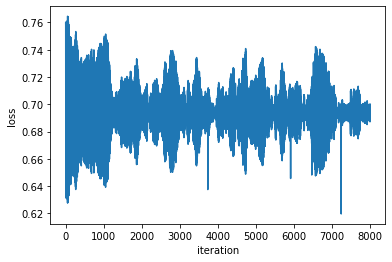

In [13]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

[0.69428853 0.69365666 0.69353904 0.69358433 0.69351278 0.69358723
 0.69354898 0.69357859 0.6933345  0.69363309]


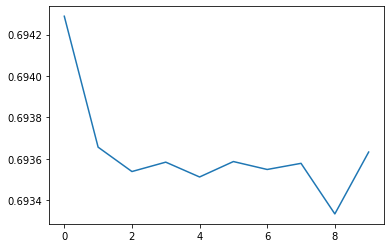

In [18]:
avg_losses = np.mean(np.reshape(np.array(losses),(n_epochs,-1)),axis=1)
print(avg_losses)
plt.plot(avg_losses)
plt.show()

In [15]:
dataiter = iter(testLoader)
true = []
predict = []
for d in dataiter:
    images = d['input']
    labels = d['target']
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
    predict.append(predicted)
    true.append(labels)

tensor([[0.4929, 0.5071]], grad_fn=<SoftmaxBackward>)


/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [19]:
correct = 0
total = 0
snb = 0
radio = 0
with torch.no_grad():
    for d in testLoader:
        images = d ['input']
        labels = d ['target']
        outputs = net(images)
        print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        snb += (predicted == 1).sum().item()
        radio += (predicted == 0).sum().item()

        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("SNB: {}".format(snb))
print("Radio: {}".format(radio))

/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
t

tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
tensor([[0.4929, 0.5071]])
t

In [20]:
from sklearn.metrics import confusion_matrix
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        images = data['input']
        labels = data['target']
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(2):
            label = classes[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



tensor([[0.4929, 0.5071]])


/home/lewis/.conda/envs/SparseAIEnv/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


TypeError: list indices must be integers or slices, not str

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()